# Исследование данных HR-агенства

## 1. Постановка задачи
HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе анализа необходимо:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. Ответить на ключевые вопросы HR-агентства:
    * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


Для этого проведем анализ датасета с зарплатами в сфере Data Science.

Данные содержат следующие столбцы:

* work_year - год, в котором была выплачена зарплата.
* experience_level - опыт работы на этой должности в течение года со следующими возможными значениями:
    * EN — Entry-level/Junior;
    * MI — Mid-level/Intermediate;
    * SE — Senior-level/Expert;
    * EX — Executive-level/Director.
* employment_type - тип трудоустройства для этой роли:
    * PT — неполный рабочий день;
    * FT — полный рабочий день;
    * CT — контракт;
    * FL — фриланс.
* job_title - роль, в которой соискатель работал в течение года.
* salary - общая выплаченная валовая сумма заработной платы.
* salary_currency - валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* salary_in_usd - зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* employee_residence - основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* remote_ratio - общий объём работы, выполняемой удалённо. Возможные значения:
    * 0 — удалённой работы нет (менее 20 %);
    * 50 — частично удалённая работа;
    * 100 — полностью удалённая работа (более 80 %).
* company_location - страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size - среднее количество людей, работавших в компании в течение года:
    * S — менее 50 сотрудников (небольшая компания);
    * M — от 50 до 250 сотрудников (средняя компания);
    * L — более 250 сотрудников (крупная компания).

***

## 2. Загрузка данных

In [2]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [3]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv', index_col = 'Unnamed: 0')
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [4]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


***

## 3. Описательный анализ данных

### 3.1. Найдем пропущенные значения в датасете:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


Видим, что в датасете 607 записей. Нет пропущенных значений.

***

### 3.2. Проверим данные на наличие полных дубликатов:

In [6]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:

data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


***

### 3.3. Проверим корректность типов данных столбцов:

In [7]:
# Исправим тип данных в столбце remote_ratio с int64 на object:

data['remote_ratio'] = data['remote_ratio'].astype(object)

# Проверим тип данных после изменения: 

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   employment_type     565 non-null    object
 3   job_title           565 non-null    object
 4   salary              565 non-null    int64 
 5   salary_currency     565 non-null    object
 6   salary_in_usd       565 non-null    int64 
 7   employee_residence  565 non-null    object
 8   remote_ratio        565 non-null    object
 9   company_location    565 non-null    object
 10  company_size        565 non-null    object
dtypes: int64(3), object(8)
memory usage: 53.0+ KB


***

### 3.4. Найдем неинформативные признаки, которые можно сразу удалить, чтобы не загружать датасет лишней информацией.

Проанализировав ключевые вопросы от HR-агенства и признаки, имеющиеся в датасете, выявим следующие признаки, которые не пригодятся в исследовании:

* salary - общая выплаченная валовая сумма заработной платы.
* salary_currency - валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.

In [8]:
data = data.drop(['salary', 'salary_currency'], axis = 1)

***

### 3.5. Классифицируем все признаки на числовые и категориальные, чтобы корректно провести статистический анализ:

**Числовые признаки:**

* work_year - год, в котором была выплачена зарплата;
* salary_in_usd - зарплата в долларах США;

**Категориальные признаки:**

* experience_level - опыт работы на этой должности в течение года;
* employment_type - тип трудоустройства для этой роли;
* job_title - роль, в которой соискатель работал в течение года;
* employee_residence - основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
* remote_ratio - общий объём работы, выполняемой удалённо;
* company_location - страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size - среднее количество людей, работавших в компании в течение года.

***

### 3.6. Найдем основные статистические характеристики для каждого из признаков:

In [9]:
# Признак work_year:
data_w_y_describe = data['work_year'].describe().round(2).to_frame()
data_w_y_describe.columns = ['Год, в котором была выплачена з/п']
data_w_y_describe

,"Год, в котором была выплачена з/п"
count,565.00
mean,2021.36
std,0.70
min,2020.00
25%,2021.00
50%,2021.00
75%,2022.00
max,2022.00


Заметим, что в данных нет лишних значений, которые бы не относились к условиям анализа - т.е. года представлены с 2020 по 2022.

In [10]:
# Признак experience_level:
data_e_l_describe = data['experience_level'].describe().to_frame()
data_e_l_describe.columns = ['Опыт работы на должности в течение года']
data_e_l_describe

,Опыт работы на должности в течение года
count,565
unique,4
top,SE
freq,243


Для категориальных признаков количество статистических характеристик намного меньше. Всего уникальных значений - 4. Самое частое - SE (Senior-level/Expert), оно повторяется 243 раза.

In [11]:
# Признак employment_type:
data_e_t_describe = data['employment_type'].describe().to_frame()
data_e_t_describe.columns = ['Тип трудоустройства']
data_e_t_describe

,Тип трудоустройства
count,565
unique,4
top,FT
freq,546


Уникальных значений - 4. Самое частое - FT - полный рабочий день (546 раз)

In [12]:
# Признак job_title:
data_j_t_describe = data['job_title'].describe().to_frame()
data_j_t_describe.columns = ['Роль, в которой соискатель работал в течение года']
data_j_t_describe

,"Роль, в которой соискатель работал в течение года"
count,565
unique,50
top,Data Scientist
freq,130



Уникальных значений - 50. Самое частое - Data Scientist (130 раз)

In [13]:
# Признак salary_in_usd:
data_s_u_describe = data['salary_in_usd'].describe().round(2).to_frame()
data_s_u_describe.columns = ['Зарплата в долларах США']
data_s_u_describe

,Зарплата в долларах США
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


Среднее значение зарплаты по всему датасету - 110 610.34 долларов США

In [14]:
# Признак employee_residence:
data_e_r_describe = data['employee_residence'].describe().to_frame()
data_e_r_describe.columns = ['Основная страна проживания сотрудника в течение рабочего года']
data_e_r_describe

,Основная страна проживания сотрудника в течение рабочего года
count,565
unique,57
top,US
freq,295


Уникальных значений - 57. Самое частое - US (295 раз)

In [15]:
# Признак remote_ratio:
data_r_r_describe = data['remote_ratio'].describe().round(2).to_frame()
data_r_r_describe.columns = ['Общий объем работы, выполняемой удаленно']
data_r_r_describe

,"Общий объем работы, выполняемой удаленно"
count,565
unique,3
top,100
freq,346


Уникальный значений - 3. Самое частое - 100 % выполняемой работы удаленно (346 раз)

In [16]:
# Признак company_location:
data_c_l_describe = data['company_location'].describe().to_frame()
data_c_l_describe.columns = ['Cтрана главного офиса работодателя или филиала по контракту']
data_c_l_describe

,Cтрана главного офиса работодателя или филиала по контракту
count,565
unique,50
top,US
freq,318


Уникальных значений - 50. Самое частое - US (318 раз)

In [17]:
# Признак company_size:
data_c_z_describe = data['company_size'].describe().to_frame()
data_c_z_describe.columns = ['Cреднее количество людей, работавших в компании в течение года']
data_c_z_describe

,"Cреднее количество людей, работавших в компании в течение года"
count,565
unique,3
top,M
freq,290


Уникальных значений - 3. Самое частое - M - средняя компания от 50 до 250 сотрудников (290 раз)

***


### 3.7. Переобозначим company_size и remote_ratio в более понятный формат

In [18]:
def company_size(size):
    if size == 'L':
        return 'Крупная компания'
    elif size == 'M':
        return 'Средняя компания'
    elif size == 'S':
        return 'Небольшая компания'
     
data['company_size']=data['company_size'].apply(company_size)

In [19]:
def remote_ratio(size):
    if size == 0:
        return 'Удалённой работы нет'
    elif size == 50:
        return 'Частично удалённая работа'
    elif size == 100:
        return 'Полностью удалённая работа'
     
data['remote_ratio']=data['remote_ratio'].apply(remote_ratio)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           565 non-null    int64 
 1   experience_level    565 non-null    object
 2   employment_type     565 non-null    object
 3   job_title           565 non-null    object
 4   salary_in_usd       565 non-null    int64 
 5   employee_residence  565 non-null    object
 6   remote_ratio        565 non-null    object
 7   company_location    565 non-null    object
 8   company_size        565 non-null    object
dtypes: int64(2), object(7)
memory usage: 44.1+ KB


***

## 4. Разведывательный анализ данных

### 4.1. Визуальный анализ основных данных
### Какие факторы влияют на зарплату специалиста Data Scientist?

#### 4.1.1. Распределение заплаты специалиста Data Scientist

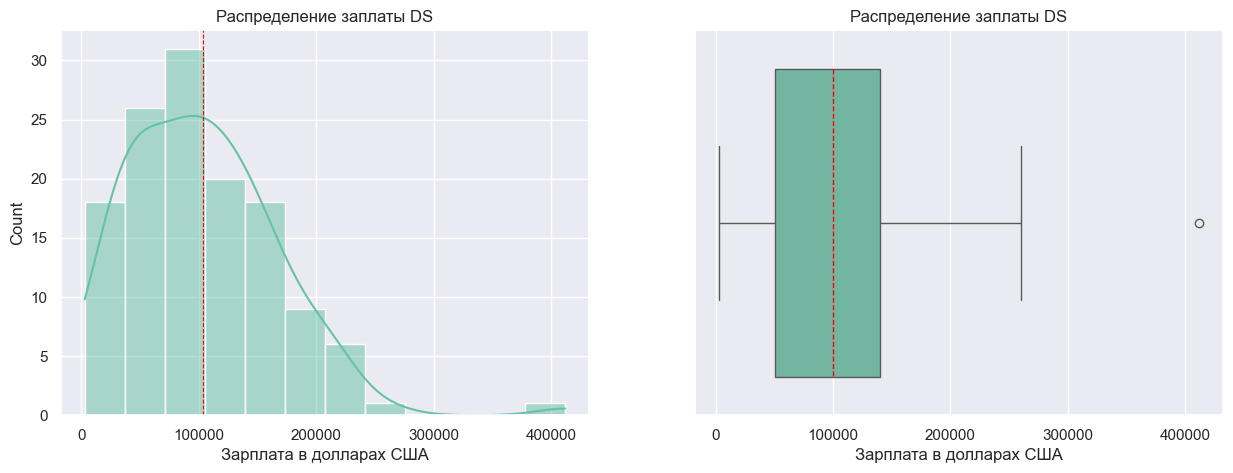

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Создадим маску по которой будем проверять специалистов Data Scientist на протяжении всего ноутбука
data_DS = data[data['job_title'] == 'Data Scientist']

# Создадим первый график - гистрограмму распределения; устанавливаем параметр kde = True, чтобы вычислить оценку плотности ядра, 
# чтобы сгладить распределение и отобразить на графике в виде линии:

sns.histplot(data_DS['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в долларах США')
axes[0].set_title('Распределение заплаты DS')
axes[0].axvline(data_DS['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data_DS['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Зарплата в долларах США')
axes[1].set_title('Распределение заплаты DS')

plt.show()

In [22]:
# Признак salary_in_usd:
data_s_u_describe = data_DS['salary_in_usd'].describe().round(2).to_frame()
data_s_u_describe.columns = ['Зарплата в долларах США']
data_s_u_describe

,Зарплата в долларах США
count,130.00
mean,103336.35
std,63967.56
min,2859.00
25%,50330.25
50%,100000.00
75%,140400.00
max,412000.00


#### Вывод:
Распределение немного приближено к нормальному, но есть выбросы (начиная от 300 000 долларов США). Медианное значение практически равно среднему - 100 000 долларов США.

***

#### 4.1.2. Как изменялась зарплата специалиста Data Scientist 2020-2022гг

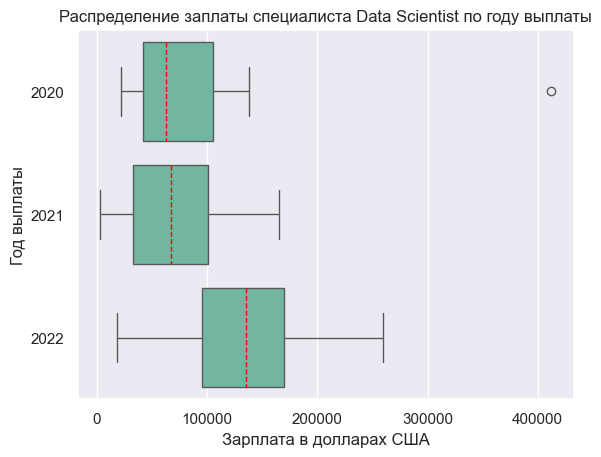

In [23]:
ax = sns.boxplot(data_DS, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата в долларах США', ylabel='Год выплаты')
plt.title('Распределение заплаты специалиста Data Scientist по году выплаты')
plt.show()


In [24]:
data_agg = data_DS.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Распределение заплаты специалиста Data Scientist по году выплаты')
data_agg

Распределение заплаты специалиста Data Scientist по году выплаты


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.00,62726.0,105000.00,412000.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


#### Вывод:
Выводы: можно отметить рост медианной и средней зарплаты с 2020 по 2022 гг. Особенно виден рост зарплат в 2022 году, где нижний квантиль немного меньше, чем верхний в 2020 и 2021 году.

Также отметим выброс в 2020 году - зарплата 412 000 долларов.

***

### 4.1.3. Влияет ли опыт работы на зарплату специалиста Data Scientist?

### Анализ специалистов всего датасета

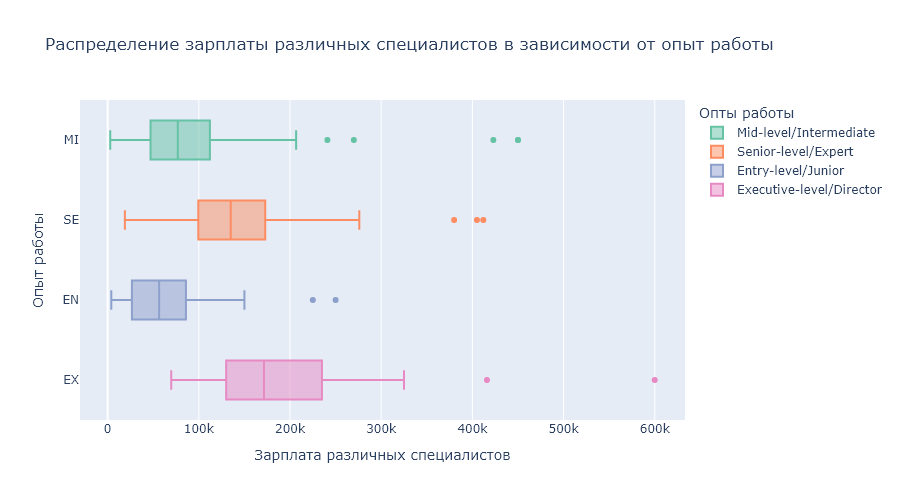

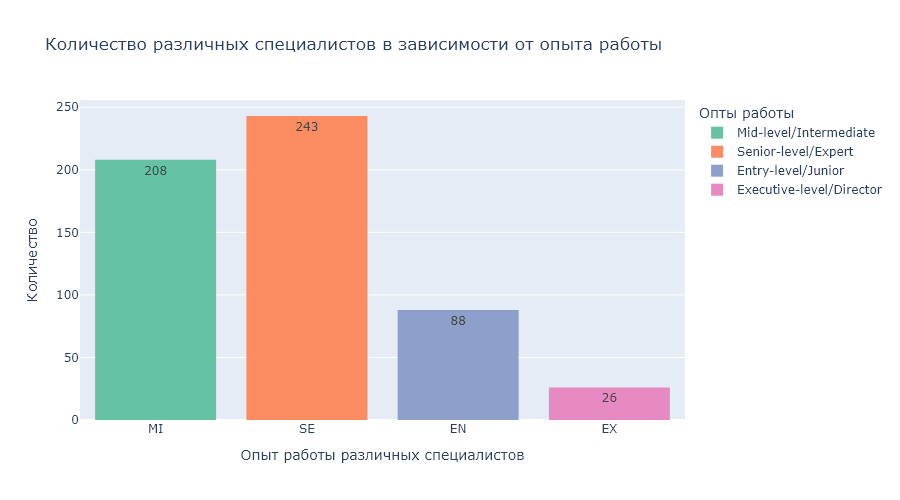

In [25]:
fig1 = px.box(
    data,
    x='salary_in_usd',
    y = 'experience_level',
    height=500, 
    width=900, 
    title = 'Распределение зарплаты различных специалистов в зависимости от опыт работы', 
    labels = {'experience_level': 'Опты работы'},
    color = 'experience_level', 
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig1.update_layout(xaxis_title_text = 'Зарплата различных специалистов', yaxis_title_text='Опыт работы ')
newnames = {'EN':'Entry-level/Junior', 'EX': 'Executive-level/Director', 'MI':'Mid-level/Intermediate', 'SE':'Senior-level/Expert'}
fig1.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig1.show('png')

# Чтобы визуально оценить распределение опыта работы построим гистограммы c помощью метода px.histogram библиотеки plotly.express. 
# Выставим параметр text_auto = True, чтобы на графике отобразить количество записей для каждой категории:

fig2 = px.histogram(
    data, 
    x = 'experience_level',
    height=500, 
    width=900, 
    title = 'Количество различных специалистов в зависимости от опыта работы', 
    labels = {'experience_level': 'Опты работы'},
    text_auto = True, 
    color = 'experience_level', 
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig2.update_layout(xaxis_title_text = 'Опыт работы различных специалистов', yaxis_title_text='Количество')
newnames = {'EN':'Entry-level/Junior', 'EX': 'Executive-level/Director', 'MI':'Mid-level/Intermediate', 'SE':'Senior-level/Expert'}
fig2.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig2.show('png')

### Анализ специалистов Data Scientist

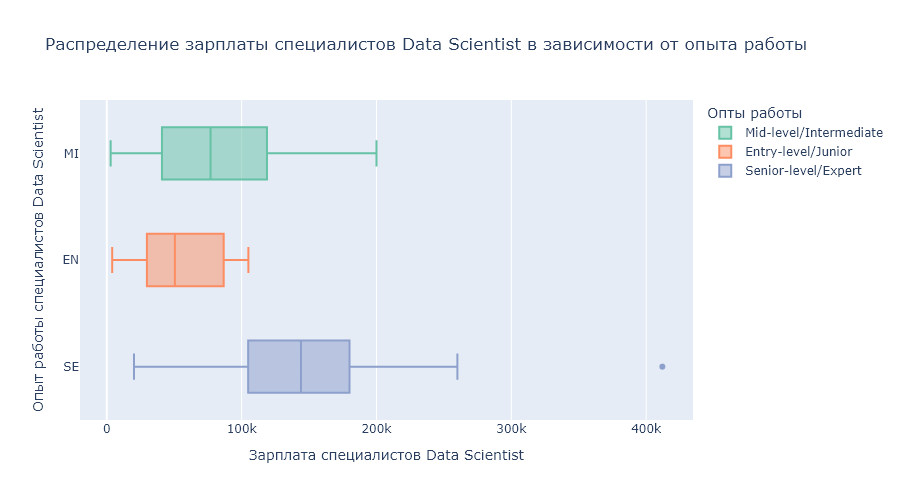

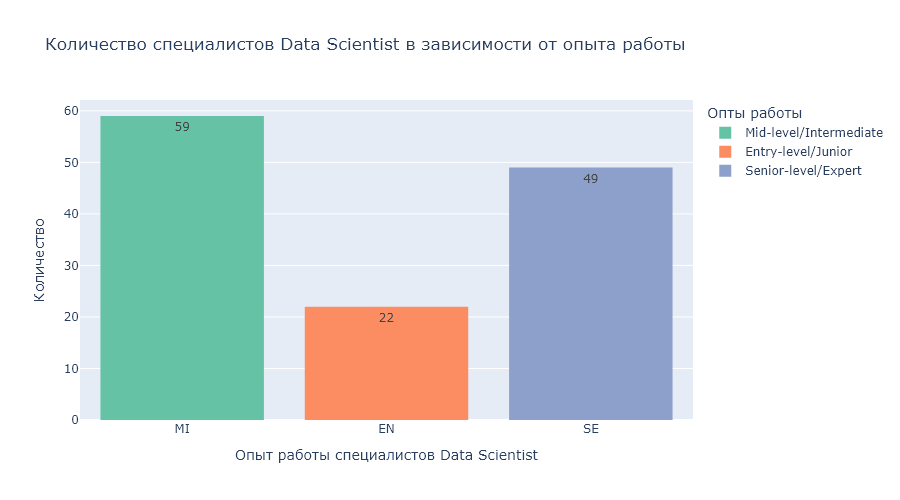

In [26]:
fig = px.box(
    data_DS,
    x='salary_in_usd',
    y = 'experience_level',
    height=500, 
    width=900, 
    title = 'Распределение зарплаты специалистов Data Scientist в зависимости от опыта работы', 
    labels = {'experience_level': 'Опты работы'},
    color = 'experience_level', 
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig.update_layout(xaxis_title_text = 'Зарплата специалистов Data Scientist', yaxis_title_text='Опыт работы специалистов Data Scientist')
newnames = {'EN':'Entry-level/Junior', 'EX': 'Executive-level/Director', 'MI':'Mid-level/Intermediate', 'SE':'Senior-level/Expert'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig.show('png')

# Чтобы визуально оценить распределение опыта работы построим гистограммы c помощью метода px.histogram библиотеки plotly.express. 
# Выставим параметр text_auto = True, чтобы на графике отобразить количество записей для каждой категории:

fig2 = px.histogram(
    data_DS, 
    x = 'experience_level',
    height=500, 
    width=900, 
    title = 'Количество специалистов Data Scientist в зависимости от опыта работы', 
    labels = {'experience_level': 'Опты работы'},
    text_auto = True, 
    color = 'experience_level', 
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig2.update_layout(xaxis_title_text = 'Опыт работы специалистов Data Scientist', yaxis_title_text='Количество')
newnames = {'EN':'Entry-level/Junior', 'EX': 'Executive-level/Director', 'MI':'Mid-level/Intermediate', 'SE':'Senior-level/Expert'}
fig2.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig2.show('png')

In [27]:
data_agg = data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Распределение заплаты различных специалистов в зависимости от опыта работы')
data_agg

Распределение заплаты различных специалистов в зависимости от опыта работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.32,44395.54,4000.0,27505.00,56500.0,85425.75,250000.0
EX,26.0,199392.04,117071.26,69741.0,130006.50,171437.5,233750.00,600000.0
MI,208.0,87793.00,64118.97,2859.0,47163.75,76940.0,112075.00,450000.0
SE,243.0,138374.88,59955.97,18907.0,99531.50,135000.0,171881.00,412000.0


In [28]:
data_agg = data_DS.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Распределение заплаты специалиста Data Scientist в зависимости от опыта работы')
data_agg

Распределение заплаты специалиста Data Scientist в зависимости от опыта работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,59.0,81891.76,47257.88,2859.0,41339.0,76958.0,118529.50,200000.0
SE,49.0,150710.86,62918.63,20171.0,104890.0,144000.0,180000.00,412000.0


#### Вывод:
 Больше всего в датасете специалистов с категорией опыта работы SE (Senior-level/Expert), меньше всего - EX (Executive-level/Director). Cамая маленькая медианная и средняя зарплата у специалистов с минимальным опытом работы - EN (Entry-level/Junior), самая большая - у EX (Executive-level/Director - высшие должности в организациях).

***

### 4.1.2. Влияет ли тип трудоустройства на зарплату специалиста Data Scientist?

### Анализ специалистов всего датасета

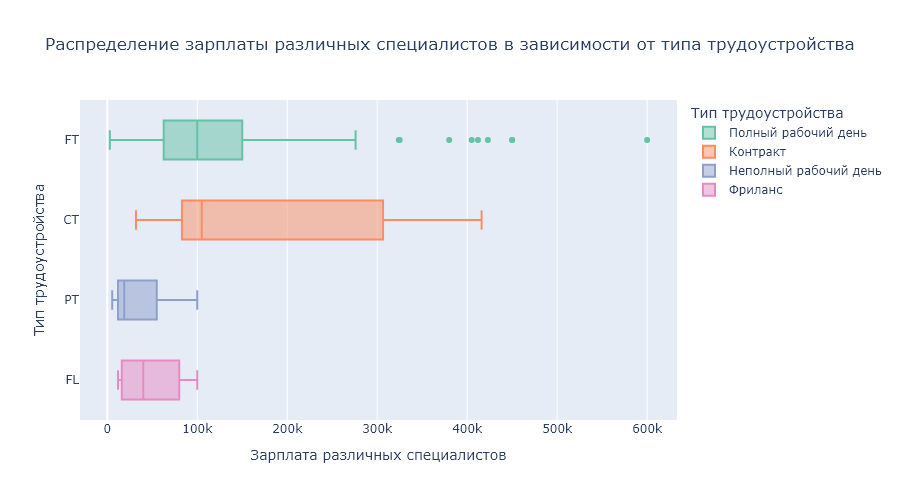

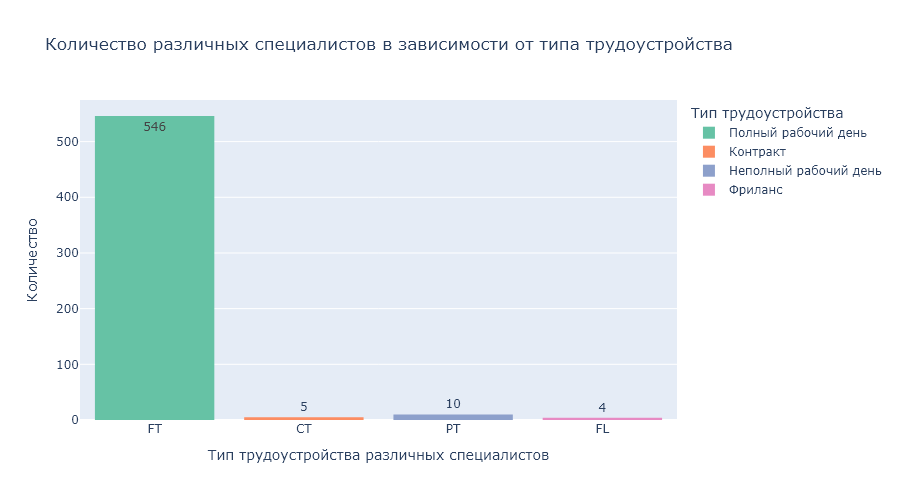

In [29]:
fig1 = px.box(
    data, 
    x = 'salary_in_usd', 
    y='employment_type',
    height=500, 
    width=900,
    title = 'Распределение зарплаты различных специалистов в зависимости от типа трудоустройства', 
    labels = {'employment_type': 'Тип трудоустройства'},
    color = 'employment_type',
    color_discrete_sequence = px.colors.qualitative.Set2
   
)
fig1.update_layout(xaxis_title_text = 'Зарплата различных специалистов', yaxis_title_text='Тип трудоустройства')
newnames = {'PT':'Неполный рабочий день', 'FT': 'Полный рабочий день', 'CT':'Контракт', 'FL':'Фриланс'}
fig1.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig1.show('png')

fig2 = px.histogram(
    data, 
    x = 'employment_type', 
    height=500, 
    width=900,
    title = 'Количество различных специалистов в зависимости от типа трудоустройства', 
    labels = {'employment_type': 'Тип трудоустройства'},
    text_auto = True,
    color = 'employment_type',
    color_discrete_sequence = px.colors.qualitative.Set2
   
)
fig2.update_layout(xaxis_title_text = 'Тип трудоустройства различных специалистов', yaxis_title_text='Количество')
newnames = {'PT':'Неполный рабочий день', 'FT': 'Полный рабочий день', 'CT':'Контракт', 'FL':'Фриланс'}
fig2.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig2.show('png')

### Анализ специалистов Data Scientist

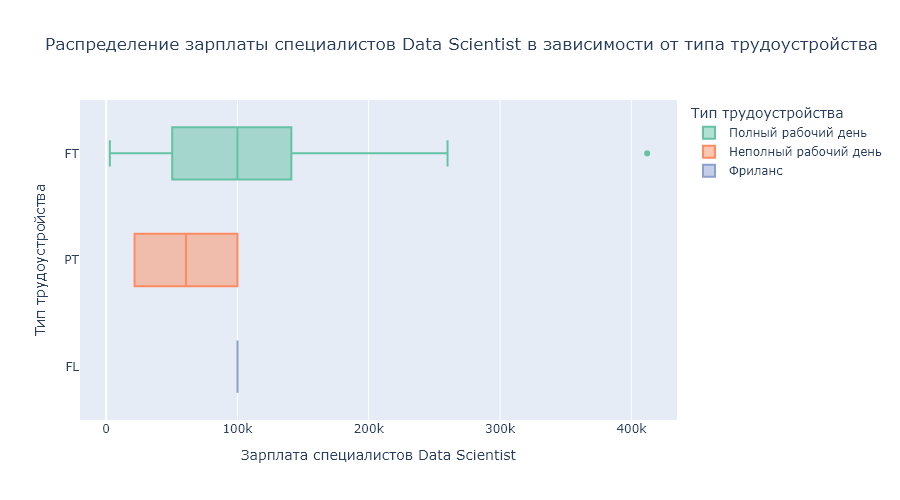

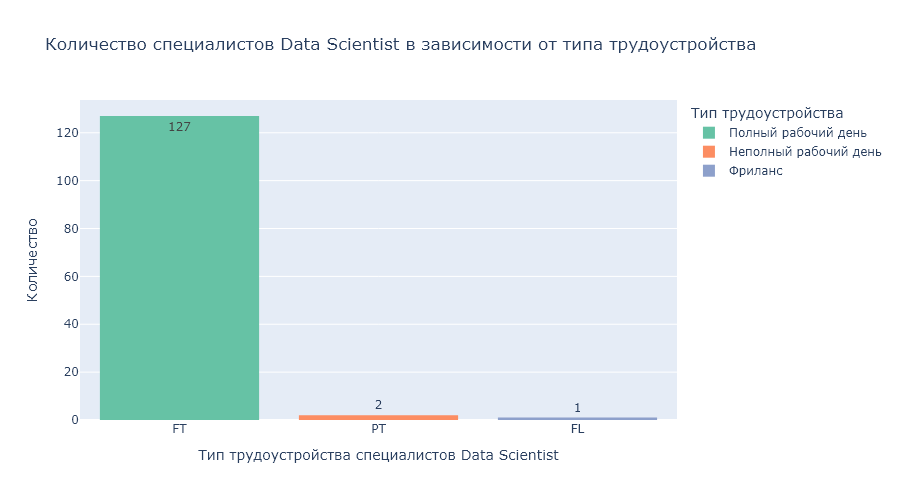

In [30]:
fig1 = px.box(
    data_DS, 
    x = 'salary_in_usd', 
    y='employment_type',
    height=500, 
    width=900,
    title = 'Распределение зарплаты специалистов Data Scientist в зависимости от типа трудоустройства', 
    labels = {'employment_type': 'Тип трудоустройства'},
    color = 'employment_type',
    color_discrete_sequence = px.colors.qualitative.Set2
   
)
fig1.update_layout(xaxis_title_text = 'Зарплата специалистов Data Scientist', yaxis_title_text='Тип трудоустройства')
newnames = {'PT':'Неполный рабочий день', 'FT': 'Полный рабочий день', 'CT':'Контракт', 'FL':'Фриланс'}
fig1.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig1.show('png')

fig2 = px.histogram(
    data_DS, 
    x = 'employment_type', 
    height=500, 
    width=900,
    title = 'Количество специалистов Data Scientist в зависимости от типа трудоустройства', 
    labels = {'employment_type': 'Тип трудоустройства'},
    text_auto = True,
    color = 'employment_type',
    color_discrete_sequence = px.colors.qualitative.Set2
   
)
fig2.update_layout(xaxis_title_text = 'Тип трудоустройства специалистов Data Scientist', yaxis_title_text='Количество')
newnames = {'PT':'Неполный рабочий день', 'FT': 'Полный рабочий день', 'CT':'Контракт', 'FL':'Фриланс'}
fig2.for_each_trace(lambda t: t.update(name = newnames[t.name]))
fig2.show('png')

In [31]:
data_agg = data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Распределение заплат различных специалистов в зависимости от типа трудоустройства')
data_agg

Распределение заплат различных специалистов в зависимости от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,5.0,184575.00,156250.89,31875.0,100000.0,105000.0,270000.0,416000.0
FL,4.0,48000.00,40529.82,12000.0,18000.0,40000.0,70000.0,100000.0
FT,546.0,111811.84,70790.70,2859.0,62726.0,100000.0,150000.0,600000.0
PT,10.0,33070.50,31472.91,5409.0,12000.0,18817.5,48370.0,100000.0


In [32]:
data_agg = data_DS.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Распределение заплаты специалистов Data Scientist в зависимости от типа трудоустройства')
data_agg

Распределение заплаты специалистов Data Scientist в зависимости от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
FL,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
FT,127.0,104031.94,64309.23,2859.0,50660.50,100000.0,140850.00,412000.0
PT,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


#### Вывод: 
Подавляющие большинство специалистов работают по графику FT (полный рабочий день), поэтому данный признак может не иметь влияния на заработную плату в сфере Data Science, и его можно не использовать в исследовании.

***

### 4.1.3. Влияет ли должность, на зарплату специалиста Data Scientist?

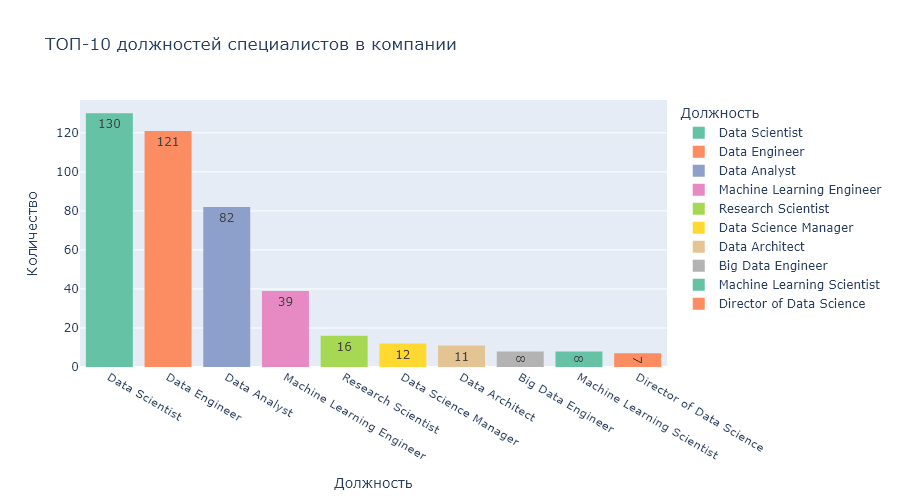

In [33]:
grouped = data.groupby(['job_title'])['salary_in_usd'].count().sort_values(ascending=False)

grouped=grouped.head(10)
fig1 = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    title = 'ТОП-10 должностей специалистов в компании',
    labels = {'job_title': 'Должность'},
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig1.update_layout(xaxis_title_text = 'Должность', yaxis_title_text='Количество')
fig1.show('png')


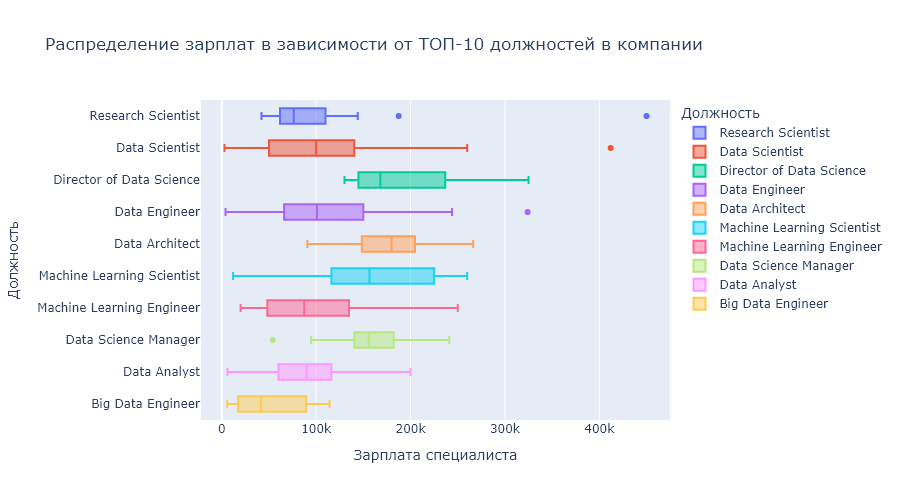

In [34]:
data_job_title_top10 = data[data['job_title'].isin(['Data Scientist', 'Data Engineer', 'Data Analyst', 'Machine Learning Engineer', 
                                                 'Research Scientist', 'Data Science Manager', 'Data Architect', 'Big Data Engineer',
                                                 'Machine Learning Scientist', 'Director of Data Science'])]
data_job_title_top10=data_job_title_top10.sort_values(by='salary_in_usd', ascending=False)
fig2 = px.box(
    data_frame=data_job_title_top10,
    x='salary_in_usd',
    y='job_title',
    color = 'job_title',
    height=500, #высота
    width=900, #ширина
    labels = {'job_title': 'Должность'},
    title = 'Распределение зарплат в зависимости от ТОП-10 должностей в компании',
)
fig2.update_layout(xaxis_title_text = 'Зарплата специалиста')
fig2.show('png')

In [35]:

data_job_title_top10 = data_job_title_top10.groupby('job_title')['salary_in_usd'].describe().round().sort_values(by='mean', ascending=False)
print('Зависимость зарплат специалистов в сфере Data Science от должности')
data_job_title_top10

Зависимость зарплат специалистов в сфере Data Science от должности


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Director of Data Science,7.0,195074.0,70016.0,130026.0,147756.0,168000.0,223490.0,325000.0
Data Architect,11.0,177874.0,45715.0,90700.0,148900.0,180000.0,200670.0,266400.0
Machine Learning Scientist,8.0,158412.0,79515.0,12000.0,118075.0,156500.0,225000.0,260000.0
Data Science Manager,12.0,158328.0,52589.0,54094.0,142285.0,155750.0,178050.0,241000.0
Data Engineer,121.0,109750.0,58204.0,4000.0,66022.0,100800.0,150000.0,324000.0
Research Scientist,16.0,109020.0,98543.0,42000.0,62176.0,76264.0,105000.0,450000.0
Data Scientist,130.0,103336.0,63968.0,2859.0,50330.0,100000.0,140400.0,412000.0
Machine Learning Engineer,39.0,101165.0,62519.0,20000.0,49173.0,87425.0,131500.0,250000.0
Data Analyst,82.0,90090.0,40686.0,6072.0,60325.0,90000.0,116112.0,200000.0


#### Вывод: 
Cамые популярные профессии в сфере Data Science за 2020-2022 гг. - Data Scientist (130 человек), Data Engineer (121 человек), Data Analyst (82 человека). 

Самые высокие средние зарплаты в зависимости от ТОП-10 должностей в компании. Лидирующие позиции занимают:
1. Director of Data Science - 195к
2. Data Architect - 177к
3. Machine Learning Scientist - 158к

***

### 4.1.4. Влияет ли страна проживания на зарплату специалиста Data Scientist?

### Анализ специалистов всего датасета

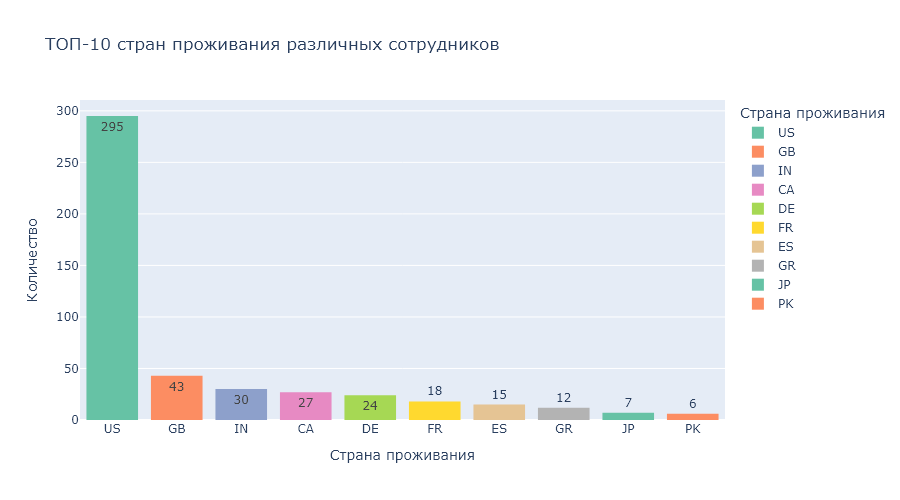

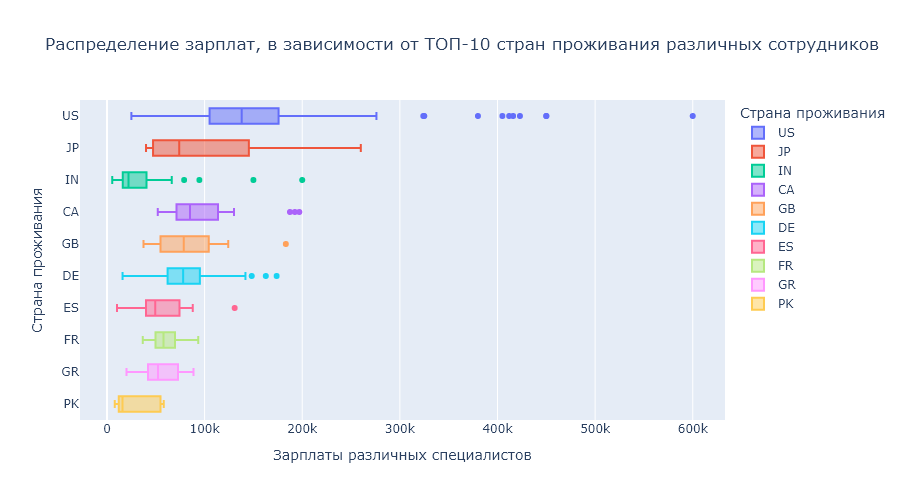

In [36]:
grouped = data.groupby(['employee_residence'])['salary_in_usd'].count().sort_values(ascending=False)

grouped=grouped.head(10)
fig1 = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    title = 'ТОП-10 стран проживания различных сотрудников',
    labels = {'employee_residence': 'Страна проживания'},
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig1.update_layout(xaxis_title_text = 'Страна проживания', yaxis_title_text='Количество')
fig1.show('png')

data_emp_res_top10 = data[data['employee_residence'].isin(['US', 'GB', 'IN', 'CA', 'DE', 'FR', 'ES', 'GR', 'JP', 'PK'])]
data_emp_res_top10=data_emp_res_top10.sort_values(by='salary_in_usd', ascending=False)
fig2 = px.box(
    data_frame=data_emp_res_top10,
    x='salary_in_usd',
    y='employee_residence',
    color = 'employee_residence',
    height=500, #высота
    width=900, #ширина
    labels = {'employee_residence': 'Страна проживания'},
    title = 'Распределение зарплат, в зависимости от ТОП-10 стран проживания различных сотрудников',
)
fig2.update_layout(xaxis_title_text = 'Зарплаты различных специалистов')
fig2.show('png')

### Анализ специалистов Data Scientist

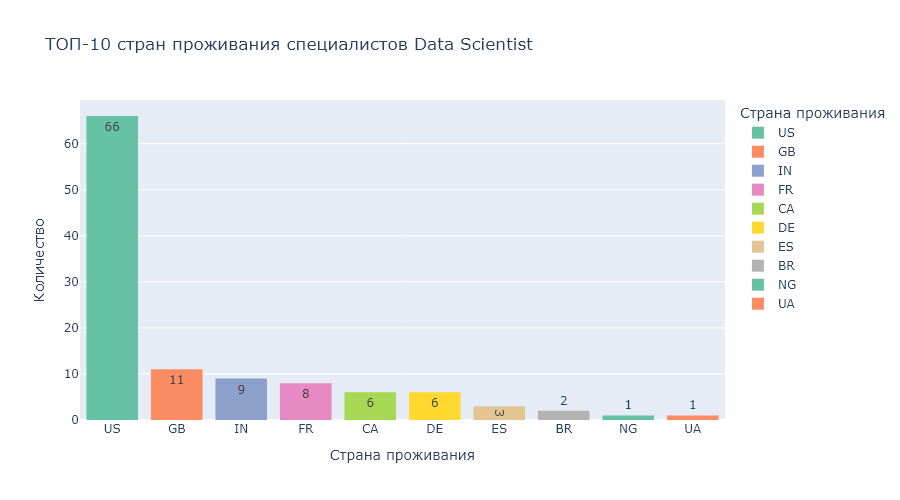

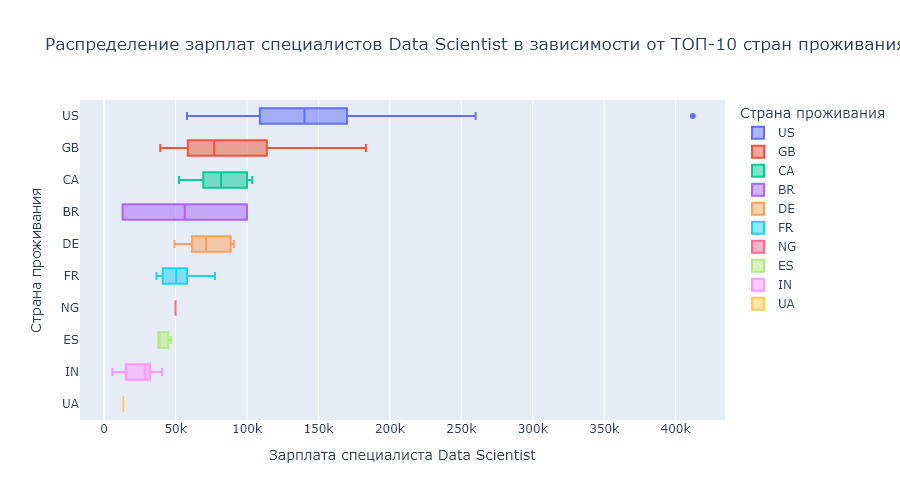

In [37]:
grouped = data_DS.groupby(['employee_residence'])['salary_in_usd'].count().sort_values(ascending=False)

grouped=grouped.head(10)
fig1 = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    title = 'ТОП-10 стран проживания специалистов Data Scientist',
    labels = {'employee_residence': 'Страна проживания'},
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig1.update_layout(xaxis_title_text = 'Страна проживания', yaxis_title_text='Количество')
fig1.show('png')

data_emp_res_top10 = data_DS[data_DS['employee_residence'].isin(['US', 'GB', 'IN', 'FR', 'CA', 'DE', 'ES', 'BR', 'NG', 'UA'])]
data_emp_res_top10=data_emp_res_top10.sort_values(by='salary_in_usd', ascending=False)
fig2 = px.box(
    data_frame=data_emp_res_top10,
    x='salary_in_usd',
    y='employee_residence',
    color = 'employee_residence',
    height=500, #высота
    width=900, #ширина
    labels = {'employee_residence': 'Страна проживания'},
    title = 'Распределение зарплат специалистов Data Scientist в зависимости от ТОП-10 стран проживания',
)
fig2.update_layout(xaxis_title_text = 'Зарплата специалиста Data Scientist')
fig2.show('png')

In [38]:
data_emp_res_top10 = data[data['employee_residence'].isin(['US', 'GB', 'IN', 'CA', 'DE', 'FR', 'ES', 'GR', 'JP', 'PK'])]
data_emp_res_top10 = data_emp_res_top10.groupby('employee_residence')['salary_in_usd'].describe().round().sort_values(by='mean', ascending=False)
print('Зависимость средних зарплат различных специалистов от страны проживания сотрудника')
data_emp_res_top10

Зависимость средних зарплат различных специалистов от страны проживания сотрудника


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
US,295.0,150095.0,70919.0,25000.0,105200.0,138000.0,175550.0,600000.0
JP,7.0,103538.0,81283.0,40000.0,52700.0,74000.0,122682.0,260000.0
CA,27.0,97192.0,40152.0,52000.0,71349.0,85000.0,110398.0,196979.0
DE,24.0,85337.0,40216.0,15966.0,62411.0,78015.0,94860.0,173762.0
GB,43.0,81470.0,30284.0,37300.0,55247.0,78526.0,103931.0,183228.0
FR,18.0,59887.0,15849.0,36643.0,49734.0,57920.0,69342.0,93427.0
ES,15.0,57593.0,28395.0,10354.0,41371.0,49461.0,71444.0,130800.0
GR,12.0,56446.0,21545.0,20000.0,43022.0,52209.0,70556.0,88654.0
IN,30.0,37322.0,43741.0,5409.0,16397.0,22124.0,38813.0,200000.0


In [39]:
data_emp_res_top10 = data_DS[data_DS['employee_residence'].isin(['US', 'GB', 'IN', 'FR', 'CA', 'DE', 'ES', 'BR', 'NG', 'UA'])]
data_emp_res_top10 = data_emp_res_top10.groupby('employee_residence')['salary_in_usd'].describe().round().sort_values(by='mean', ascending=False)
print('Зависимость средних зарплат специалистов в сфере Data Science от страны проживания сотрудника')
data_emp_res_top10

Зависимость средних зарплат специалистов в сфере Data Science от страны проживания сотрудника


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
US,66.0,147083.0,54499.0,58000.0,110500.0,140200.0,169250.0,412000.0
GB,11.0,88177.0,41394.0,39263.0,60847.0,76958.0,110808.0,183228.0
CA,6.0,81489.0,19501.0,52396.0,70946.0,81756.0,96934.0,103691.0
DE,6.0,72114.0,16753.0,49268.0,61782.0,71280.0,86449.0,90734.0
BR,2.0,56450.0,61588.0,12901.0,34676.0,56450.0,78225.0,100000.0
FR,8.0,51666.0,13412.0,36643.0,41627.0,50484.0,55576.0,77684.0
NG,1.0,50000.0,NaN,50000.0,50000.0,50000.0,50000.0,50000.0
ES,3.0,41137.0,4935.0,37825.0,38300.0,38776.0,42792.0,46809.0
IN,9.0,23838.0,11759.0,5679.0,16904.0,28399.0,31615.0,40481.0


#### Вывод: 
Больше всего сотрудников из выборки (более половины списка) проживает в US (Соединенные Штаты).
Из них в США получают среднюю зарплату - 150к.
Япония - 103к
Канада - 97к

Cамая высокая средняя и медианная зарплата у сотрудников из США (US). Также большая часть сотрудников в датасете из США. Как известно, Соединённые Штаты занимают высокие позиции в мире по ряду социально-экономических показателей, включая среднюю зарплату.

Самая маленькая зарплата(на основании оторбранных данных) у сотрудников из Пакистана (PK)

Таким образом, признак страны проживания сотрудника влияет на заработную плату. Также можно проверить гипотезу, что у сотрудников из развитых стран заработная плата больше, чем у сотрудников из развивающихся.

***

### 4.1.5. Влияет ли размер компании на зарплату специалиста Data Scientist?

### Анализ специалистов всего датасета

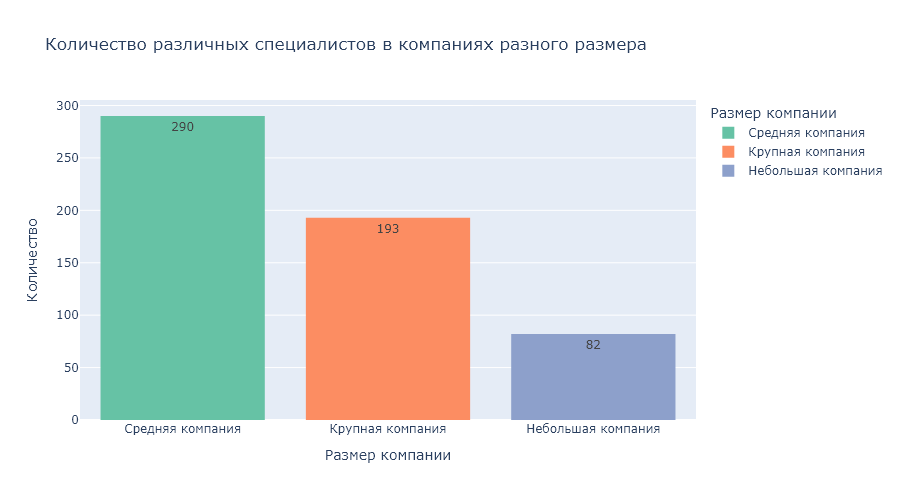

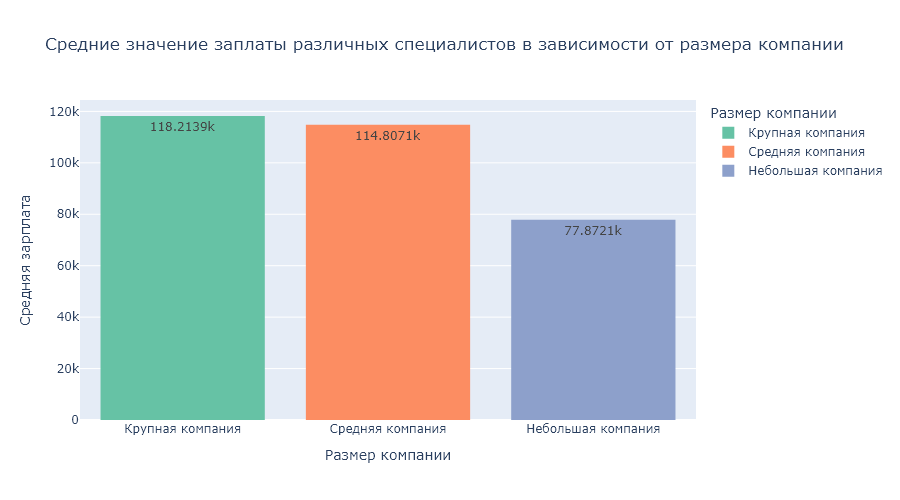

In [40]:

grouped = data.groupby(['company_size'])['salary_in_usd'].count().sort_values(ascending=False)
fig1 = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    title = 'Количество различных специалистов в компаниях разного размера',
    labels = {'company_size': 'Размер компании'},
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig1.update_layout(xaxis_title_text = 'Размер компании', yaxis_title_text='Количество')
fig1.show('png')


grouped = data.groupby(['company_size'])['salary_in_usd'].mean().sort_values(ascending=False)
fig2 = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    title = 'Средние значение заплаты различных специалистов в зависимости от размера компании',
    labels = {'company_size': 'Размер компании'},
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig2.update_layout(xaxis_title_text = 'Размер компании', yaxis_title_text='Средняя зарплата')
fig2.show('png')

### Анализ специалистов Data Scientist

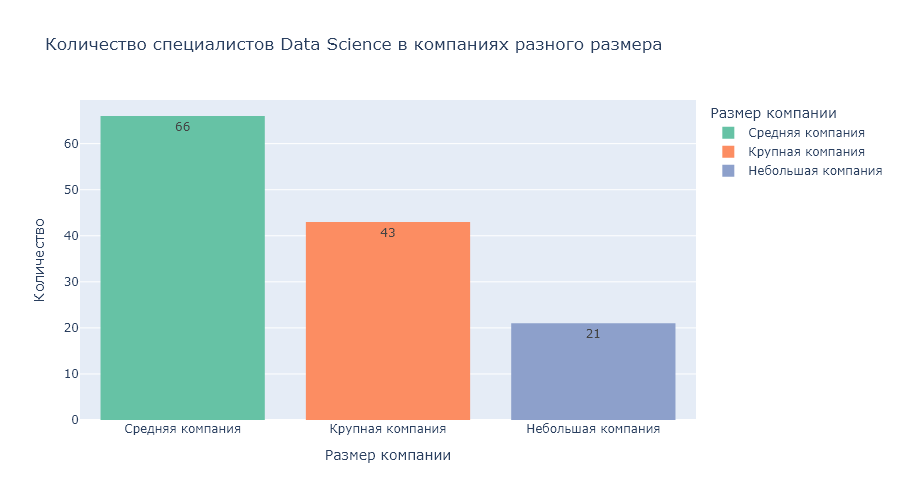

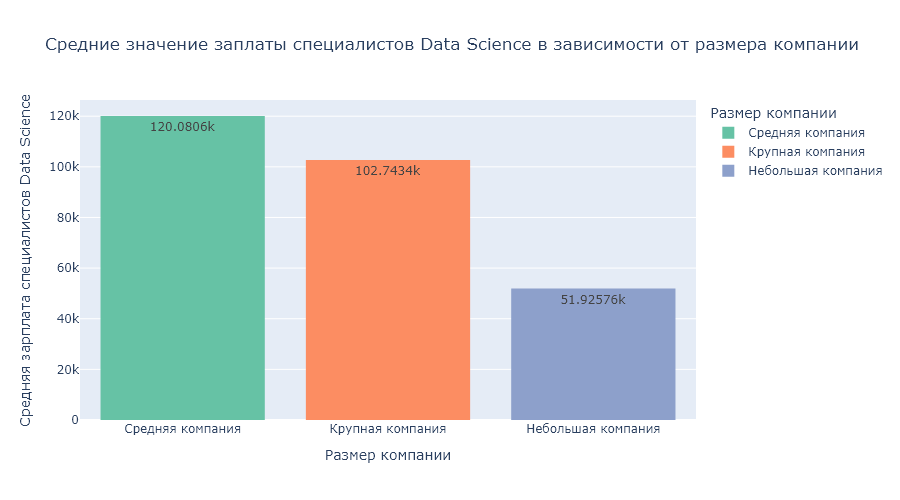

In [41]:
grouped = data_DS.groupby(['company_size'])['salary_in_usd'].count().sort_values(ascending=False)
fig1 = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    title = 'Количество специалистов Data Science в компаниях разного размера',
    labels = {'company_size': 'Размер компании'},
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig1.update_layout(xaxis_title_text = 'Размер компании', yaxis_title_text='Количество')
fig1.show('png')


grouped = data_DS.groupby(['company_size'])['salary_in_usd'].mean().sort_values(ascending=False)
fig2 = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    title = 'Средние значение заплаты специалистов Data Science в зависимости от размера компании',
    labels = {'company_size': 'Размер компании'},
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig2.update_layout(xaxis_title_text = 'Размер компании', yaxis_title_text='Средняя зарплата специалистов Data Science')
fig2.show('png')

In [42]:
data_DS_comp_size = data.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Соотношение зарплат различных специалистов в компаниях разных размеров')
data_DS_comp_size

Соотношение зарплат различных специалистов в компаниях разных размеров


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
Крупная компания,193.0,118213.88,86753.27,5882.0,60000.0,100000.0,153667.00,600000.0
Небольшая компания,82.0,77872.10,63814.52,2859.0,41816.0,65511.0,100000.00,416000.0
Средняя компания,290.0,114807.08,60779.04,4000.0,70821.5,109640.0,150213.75,450000.0


In [43]:
data_DS_comp_size = data_DS.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Соотношение зарплат специалистов Data Scientist в компаниях разных размеров')
data_DS_comp_size

Соотношение зарплат специалистов Data Scientist в компаниях разных размеров


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
Крупная компания,43.0,102743.42,73254.10,13400.0,45240.5,90734.0,135000.0,412000.0
Небольшая компания,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0
Средняя компания,66.0,120080.58,56347.79,4000.0,80000.0,119529.5,157500.0,260000.0



### Вывод: 
Больше всего компаний, где среднее количество сотрудников - M - от 50 до 250 сотрудников (средняя компания). Меньше всего - небольших компаний размера S (менее 50 сотрудников).
Интересно что средняя зарплата Data Scientist в средней компании выше чем средняя зарплата в крупной компании
Чтобы определить, являются ли эти различия статистически значимыми, далее будут проведены статистические тесты.

***

### 4.1.6. Влияет ли формат занятости на зарплату специалиста Data Scientist?

### Анализ специалистов всего датасета

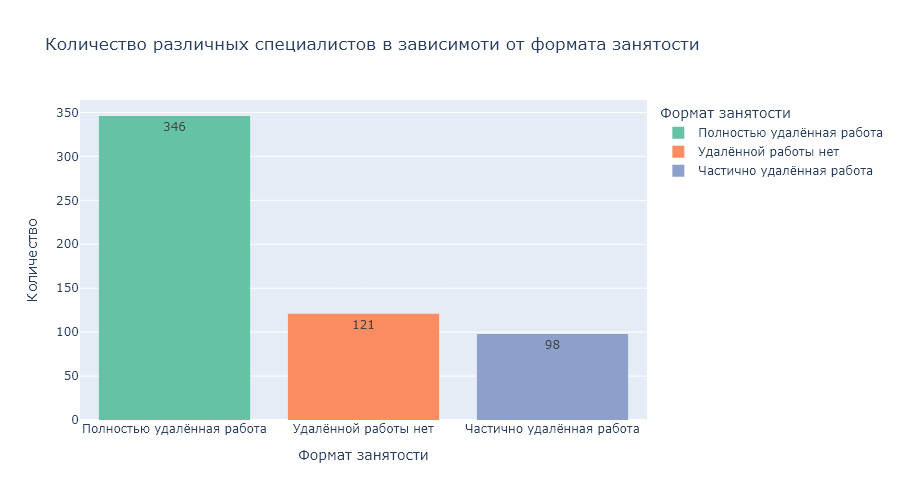

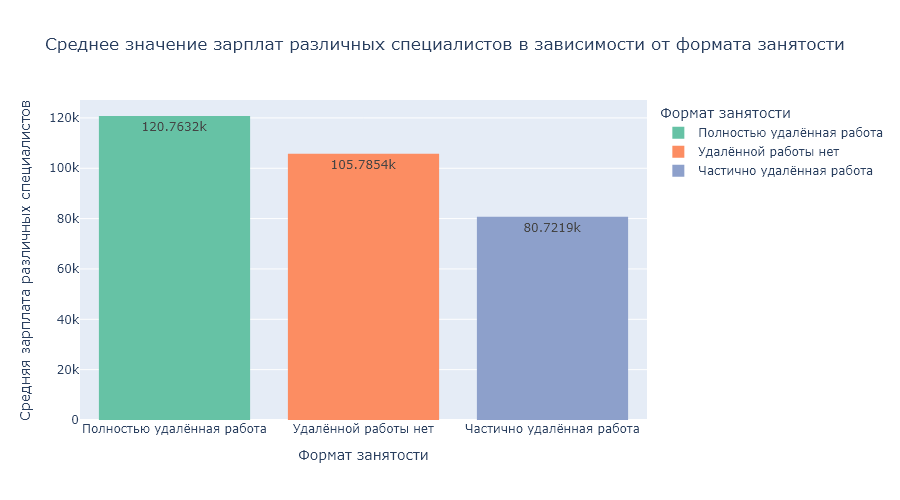

In [44]:

grouped = data.groupby(['remote_ratio'])['salary_in_usd'].count()
fig1 = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    labels = {'remote_ratio': 'Формат занятости'},
    title = 'Количество различных специалистов в зависимоти от формата занятости',
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig1.update_layout(xaxis_title_text = 'Формат занятости', yaxis_title_text='Количество')
fig1.show('png')

grouped = data.groupby(['remote_ratio'])['salary_in_usd'].mean().sort_values(ascending=False)
grouped=grouped.head(10)
fig2 = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    labels = {'remote_ratio': 'Формат занятости'},
    title = 'Среднее значение зарплат различных специалистов в зависимости от формата занятости',
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig2.update_layout(xaxis_title_text = 'Формат занятости', yaxis_title_text='Средняя зарплата различных специалистов')
fig2.show('png')

### Анализ специалистов Data Scientist

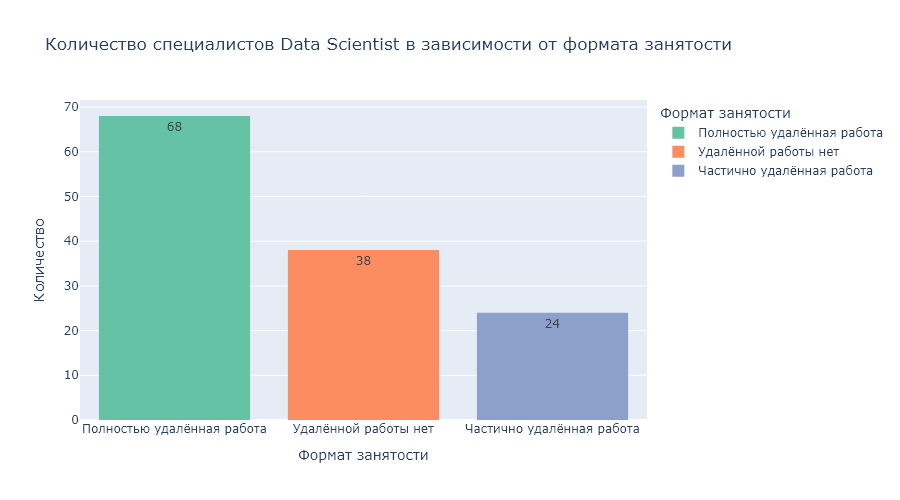

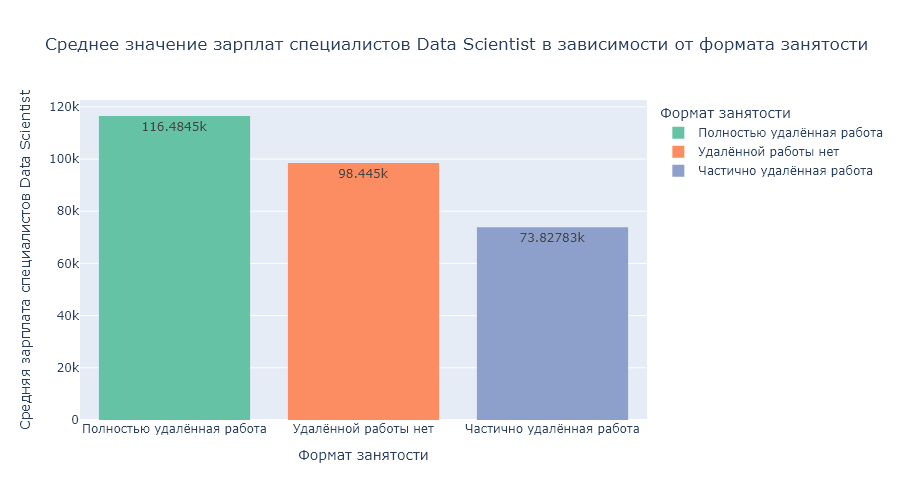

In [45]:
grouped = data_DS.groupby(['remote_ratio'])['salary_in_usd'].count()
fig1 = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    labels = {'remote_ratio': 'Формат занятости'},
    title = 'Количество специалистов Data Scientist в зависимости от формата занятости',
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig1.update_layout(xaxis_title_text = 'Формат занятости', yaxis_title_text='Количество')
fig1.show('png')

grouped = data_DS.groupby(['remote_ratio'])['salary_in_usd'].mean().sort_values(ascending=False)
fig2 = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    labels = {'remote_ratio': 'Формат занятости'},
    title = 'Среднее значение зарплат специалистов Data Scientist в зависимости от формата занятости',
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig2.update_layout(xaxis_title_text = 'Формат занятости', yaxis_title_text='Средняя зарплата специалистов Data Scientist')
fig2.show('png')

In [46]:
data_remote_ratio = data.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('зависимость зарплат различных специалистов от формата занятости')
data_remote_ratio

зависимость зарплат различных специалистов от формата занятости


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
Полностью удалённая работа,346.0,120763.19,74930.43,4000.0,70000.0,110712.5,159750.00,600000.0
Удалённой работы нет,121.0,105785.40,68392.50,2859.0,62000.0,98158.0,136000.00,450000.0
Частично удалённая работа,98.0,80721.90,57639.10,5409.0,50000.5,68010.5,99925.75,423000.0


In [47]:
data_remote_ratio = data_DS.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('зависимость зарплат специалистов в сфере Data Science от формата занятости')
data_remote_ratio

зависимость зарплат специалистов в сфере Data Science от формата занятости


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
Полностью удалённая работа,68.0,116484.54,70908.36,5679.0,64420.00,111500.0,160000.0,412000.0
Удалённой работы нет,38.0,98444.97,58647.60,2859.0,49781.25,93582.0,139050.0,215300.0
Частично удалённая работа,24.0,73827.83,36204.18,20171.0,47783.75,62726.0,102250.0,147000.0


#### Вывод: 
Более половины сотрудников (346 человек) выполняет всю свою работу удаленно. 121 человек вообще не работают в удаленном формате.

Самая высокая зарплата у сотрудников, кто полностью выполняет свою работу удаленно. По всей видимости, это удобно и выгодно для работадателя - можно не платить за аренду офиса и коммунальные услуги помещения для работы сотрудника.

На втором месте по заработной плате сотрудники, кто полностью работает в офисе. Менее всего ценится гибридный график (где работа выполняется наполовину дома, наполовину в офисе).

Таким образом, объем работы, выполняемой удаленно, влияет на заработную плату специалистов в сфере Data Science.

***

### 4.1.7. Влияет ли страна главного офиса на зарплату специалиста Data Scientist?

### Анализ специалистов всего датасета

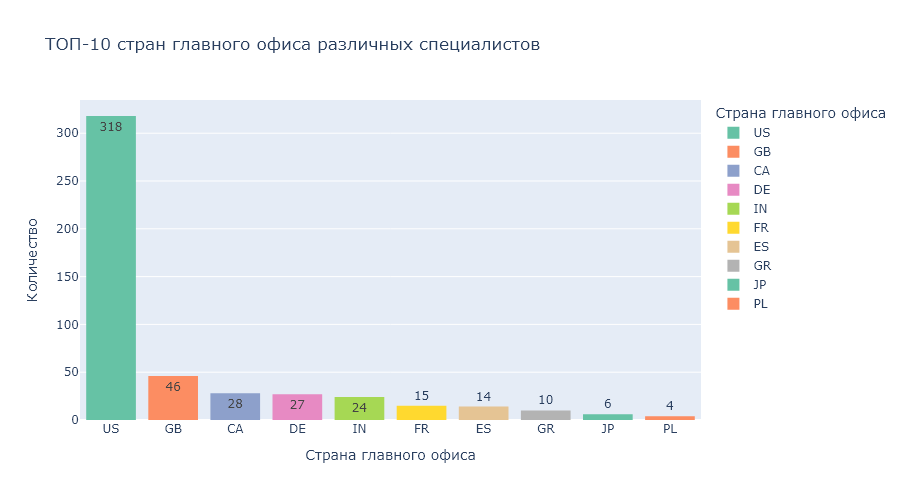

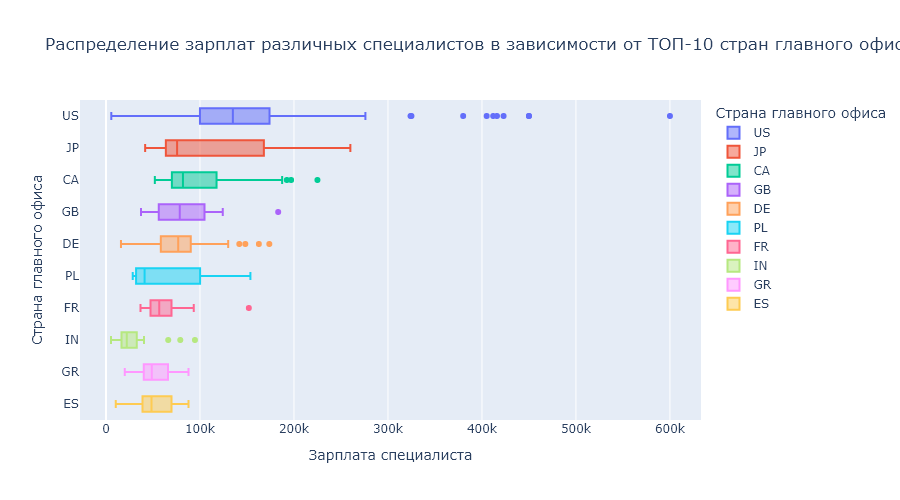

In [48]:
grouped = data.groupby(['company_location'])['salary_in_usd'].count().sort_values(ascending=False)
grouped=grouped.head(10)
fig1 = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    title = 'ТОП-10 стран главного офиса различных специалистов',
    labels = {'company_location': 'Страна главного офиса'},
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig1.update_layout(xaxis_title_text = 'Страна главного офиса', yaxis_title_text='Количество')
fig1.show('png')

data_com_loc_top10 = data[data['company_location'].isin(['US', 'GB', 'CA', 'DE', 'IN', 'FR', 'ES', 'GR', 'JP', 'PL'])]
data_com_loc_top10=data_com_loc_top10.sort_values(by='salary_in_usd', ascending=False)
fig2 = px.box(
    data_frame=data_com_loc_top10,
    x='salary_in_usd',
    y='company_location',
    color = 'company_location',
    height=500, #высота
    width=900, #ширина
    labels = {'company_location': 'Страна главного офиса'},
    title = 'Распределение зарплат различных специалистов в зависимости от ТОП-10 стран главного офиса',
)
fig2.update_layout(xaxis_title_text = 'Зарплата специалиста')
fig2.show('png')

### Анализ специалистов Data Scientist

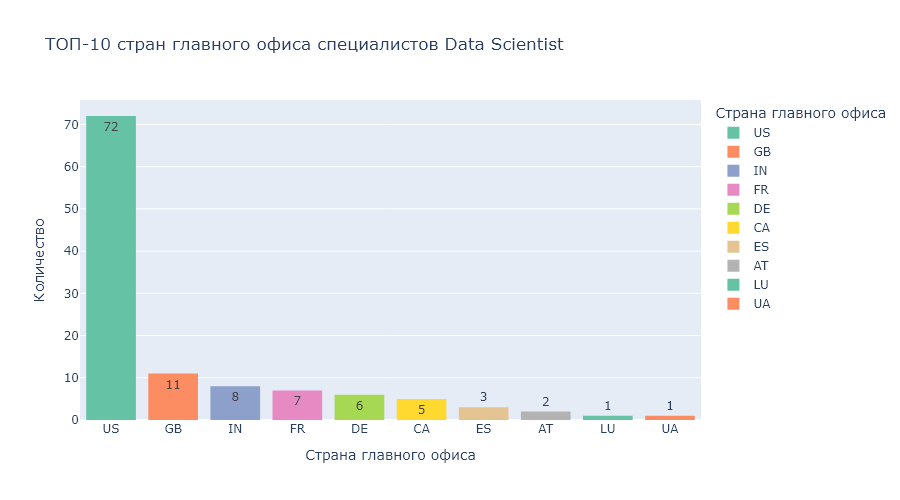

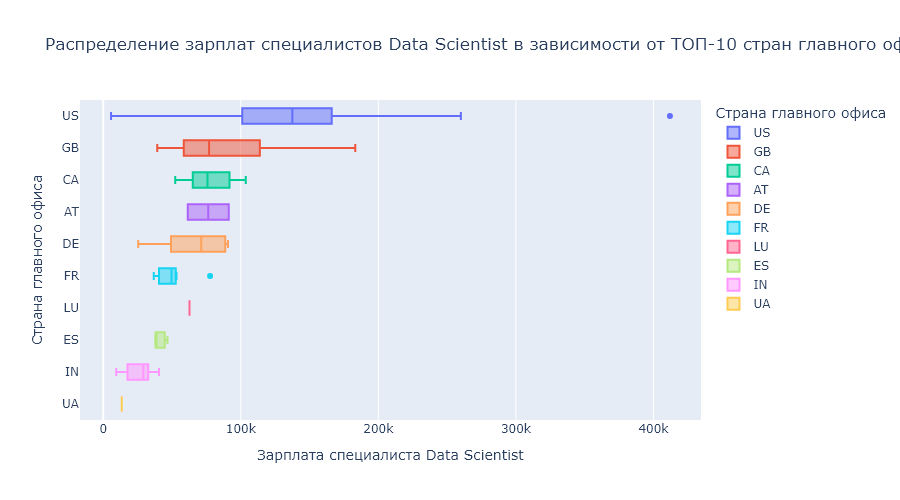

In [49]:
grouped = data_DS.groupby(['company_location'])['salary_in_usd'].count().sort_values(ascending=False)
grouped=grouped.head(10)
fig1 = px.histogram(
    data_frame=grouped,
    x=grouped.index,
    y='salary_in_usd',
    color = grouped.index,
    title = 'ТОП-10 стран главного офиса специалистов Data Scientist',
    labels = {'company_location': 'Страна главного офиса'},
    height=500, #высота
    width=900, #ширина
    text_auto = True,
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig1.update_layout(xaxis_title_text = 'Страна главного офиса', yaxis_title_text='Количество')
fig1.show('png')

data_com_loc_top10 = data_DS[data_DS['company_location'].isin(['US', 'GB', 'IN', 'FR', 'DE', 'CA', 'ES', 'AT', 'LU', 'UA'])]
data_com_loc_top10=data_com_loc_top10.sort_values(by='salary_in_usd', ascending=False)
fig2 = px.box(
    data_frame=data_com_loc_top10,
    x='salary_in_usd',
    y='company_location',
    color = 'company_location',
    height=500, #высота
    width=900, #ширина
    labels = {'company_location': 'Страна главного офиса'},
    title = 'Распределение зарплат специалистов Data Scientist в зависимости от ТОП-10 стран главного офиса',
)
fig2.update_layout(xaxis_title_text = 'Зарплата специалиста Data Scientist')
fig2.show('png')

In [50]:
data_com_loc_top10 = data[data['company_location'].isin(['US', 'GB', 'CA', 'DE', 'IN', 'FR', 'ES', 'GR', 'JP', 'PL'])]
data_com_loc_top10 = data_com_loc_top10.groupby('company_location')['salary_in_usd'].describe().round().sort_values(by='mean', ascending=False)
print('Зависимость средних зарплат различных специалистов от страны главного офиса')
data_com_loc_top10

Зависимость средних зарплат различных специалистов от страны главного офиса


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
US,318.0,144293.0,72524.0,5679.0,100000.0,135000.0,173000.0,600000.0
JP,6.0,114127.0,83585.0,41689.0,66283.0,75682.0,145341.0,260000.0
CA,28.0,100122.0,47081.0,52000.0,70518.0,81896.0,117375.0,225000.0
GB,46.0,81650.0,29847.0,37300.0,56916.0,78526.0,104316.0,183228.0
DE,27.0,81560.0,39903.0,15966.0,58669.0,76833.0,89694.0,173762.0
PL,4.0,66082.0,58864.0,28476.0,33812.0,41094.0,73364.0,153667.0
FR,15.0,63971.0,28680.0,36643.0,48202.0,56738.0,69143.0,152000.0
ES,14.0,53060.0,21091.0,10354.0,40074.0,48372.0,68793.0,87932.0
GR,10.0,52027.0,20357.0,20000.0,41133.0,48680.0,63201.0,87932.0


In [51]:
data_emp_res_top10 = data_DS[data_DS['company_location'].isin(['US', 'GB', 'IN', 'FR', 'DE', 'CA', 'ES', 'AT', 'LU', 'UA'])]
data_emp_res_top10 = data_emp_res_top10.groupby('company_location')['salary_in_usd'].describe().round().sort_values(by='mean', ascending=False)
print('Зависимость средних зарплат специалистов в сфере Data Science от страны главного офиса')
data_emp_res_top10

Зависимость средних зарплат специалистов в сфере Data Science от страны главного офиса


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
US,72.0,139935.0,58150.0,5679.0,101575.0,137485.0,165665.0,412000.0
GB,11.0,88177.0,41394.0,39263.0,60847.0,76958.0,110808.0,183228.0
CA,5.0,77787.0,19302.0,52396.0,69336.0,75774.0,87738.0,103691.0
AT,2.0,76352.0,21051.0,61467.0,68910.0,76352.0,83794.0,91237.0
DE,6.0,66124.0,25474.0,25532.0,52632.0,71280.0,86449.0,90734.0
LU,1.0,62726.0,NaN,62726.0,62726.0,62726.0,62726.0,62726.0
FR,7.0,50086.0,13659.0,36643.0,41056.0,49646.0,52256.0,77684.0
ES,3.0,41137.0,4935.0,37825.0,38300.0,38776.0,42792.0,46809.0
IN,8.0,26108.0,10248.0,9466.0,18058.0,29075.0,32163.0,40481.0


#### Вывод: 
Более половины офисов работодателей (318 шт.) расположено в US (Соединенные Штаты). Медианная и средняя зарплата больше в организациях, которые находятся в США (US), также больше половины работодателей из всего датасета расположено в США.

Самая маленькая зарплата в офисах в Индии. Аналогичные выводы были получены при анализе стран проживания сотрудников.

Дополнительно можно провести статистический анализ, чтобы проверить гипотезу - действительно ли в развитых странах зарплата у сотрудников выше, чем в развивающихся.

***

## 4.2. Ответы на ключевые вопросы HR-агентства

### 4.2.1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

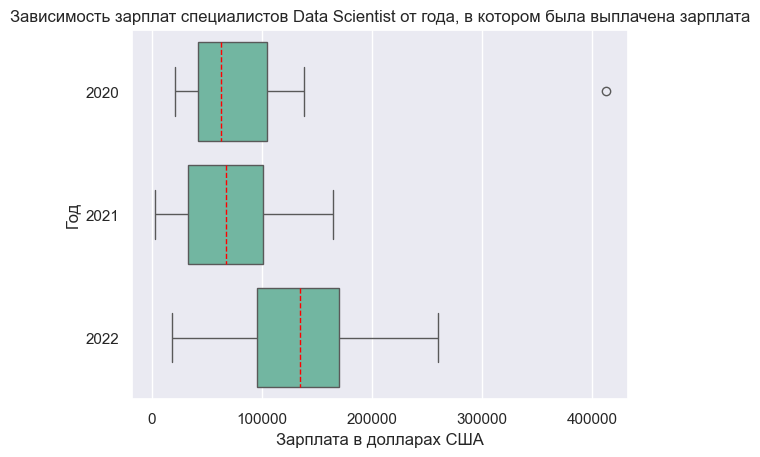

In [52]:
# Чтобы предварительно ответить на вопрос "Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?" проведем визуальный анализ.
# Подготовим данные для исследования - отфильтруем датасет по профессии Data Scientist:

data_DS = data[data['job_title'] == 'Data Scientist']

# Построим коробчатые диаграмы, чтобы понять, есть ли зависимость между признаками, и можно ли предварительно ответить на вопрос - 
# растут ли зарплаты Data Sientist-ов с каждым годом:

ax = sns.boxplot(
    data_DS, 
    x = 'salary_in_usd', 
    y = 'work_year', 
    orient = 'h', 
    medianprops = {'color' : 'red', 'linestyle' : '--'}
)

ax.set(xlabel = 'Зарплата в долларах США', ylabel = 'Год')
plt.title('Зависимость зарплат специалистов Data Scientist от года, в котором была выплачена зарплата')
plt.show()

In [53]:
# Выведем описательную статистику:

data_DS_work_year = data_DS.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Зависимость зарплат специалистов Data Scientist от года, в котором была выплачена зарплата')
data_DS_work_year

Зависимость зарплат специалистов Data Scientist от года, в котором была выплачена зарплата


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.00,62726.0,105000.00,412000.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


#### Выводы: 
Можно отметить рост медианной и средней зарплаты с 2020 по 2022 гг. Особенно виден рост зарплат в 2022 году, где нижний квантиль немного меньше, чем верхний в 2020 и 2021 году.

Также отметим выброс в 2020 году - зарплата 412 000 долларов.

***

### 4.2.2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

C:\Users\user\AppData\Local\Temp\ipykernel_7212\1799974543.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



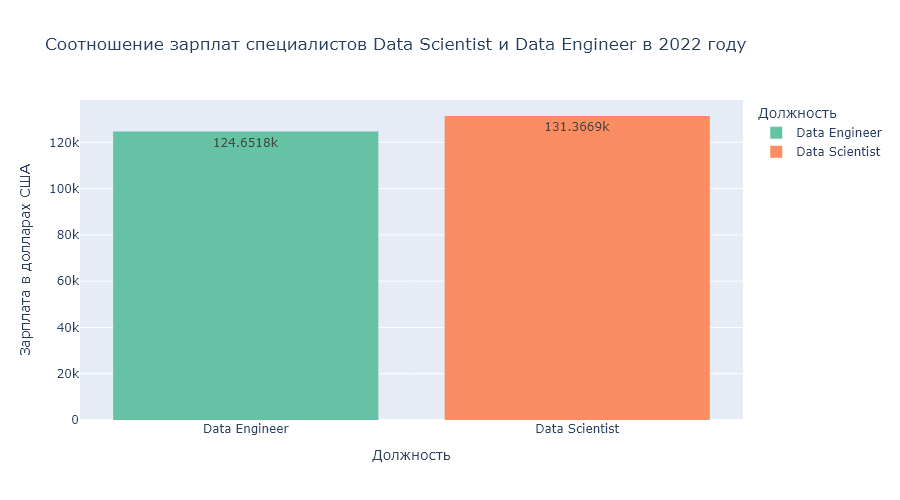

In [54]:
# Чтобы предварительно ответить на вопрос "Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?" проведем визуальный анализ.
# Подоговим данные для исследования - отфильтруем датасет по профессиям Data Scientist и Data Engineer и по 2022 году. Используем 
# для этого маски:

mask1 = data['work_year'] == 2022
mask2 = (data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')
data_DS_DE_2022 = data[mask1][mask2]

# Построим гистраграмму распределения:

fig = px.histogram(
    data_DS_DE_2022, 
    x = 'job_title', 
    y = 'salary_in_usd', 
    histfunc = 'avg',
    title = 'Cоотношение зарплат специалистов Data Scientist и Data Engineer в 2022 году', 
    labels = {'job_title': 'Должность'}, 
    text_auto = True,
    height=500, 
    width=900, 
    color = 'job_title',
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig.update_layout(xaxis_title_text = 'Должность', yaxis_title_text='Зарплата в долларах США')
fig.show('png')

In [55]:
# выведем описательную статистику:

data_DS_DE_2022_job_title = data_DS_DE_2022.groupby('job_title')['salary_in_usd'].describe().round(2)
print('Cоотношение зарплат специалистов Data Scientist и Data Engineer в 2022 году')
data_DS_DE_2022_job_title

Cоотношение зарплат специалистов Data Scientist и Data Engineer в 2022 году


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,79.0,124651.78,57846.84,25000.0,78526.0,115000.0,160040.0,324000.0
Data Scientist,65.0,131366.94,55785.24,18442.0,95550.0,135000.0,170000.0,260000.0


#### Выводы: 
Cредняя зарплата у Data Scientist в 2022 году примерно на 7 000 долларов больше, чем у Data Engineer.

***

### 4.2.3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

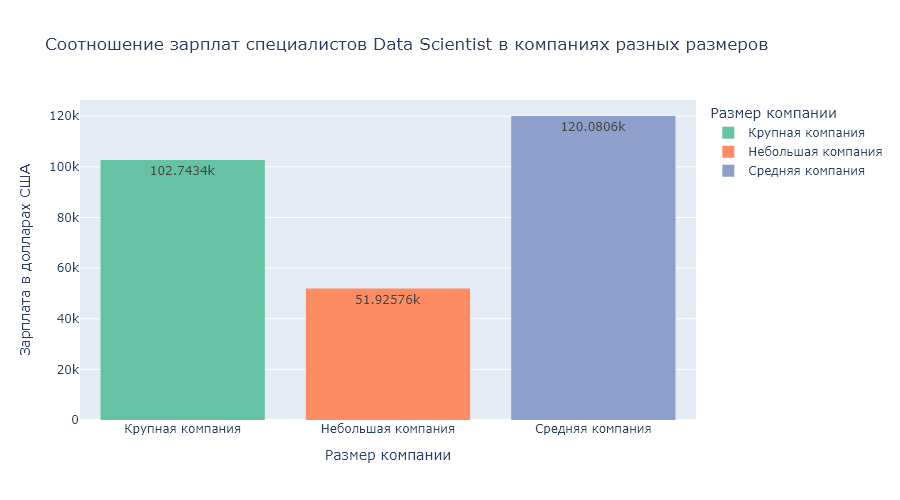

In [56]:
# Чтобы предварительно ответить на вопрос "Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?" 
# проведем визуальный анализ.
# Используем для исследования датасет data_DS, отфильтрованный по профессии Data Scientist.
# Построим гистограмму распределения средних значений зарплат salary_in_usd в зависимости от размера компаний company_size:

fig = px.histogram(
    data_DS,
    x = 'company_size', 
    y = 'salary_in_usd',
    histfunc='avg', 
    title = 'Соотношение зарплат специалистов Data Scientist в компаниях разных размеров',
    labels = {'company_size': 'Размер компании'},  
    height=500, 
    width=900, 
    text_auto = True, 
    color = 'company_size',
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig.update_layout(xaxis_title_text = 'Размер компании', yaxis_title_text='Зарплата в долларах США')
fig.show('png')

In [57]:
# Выведем описательную статистику:

data_DS_comp_size = data_DS.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Соотношение зарплат специалистов Data Scientist в компаниях разных размеров')
data_DS_comp_size

Соотношение зарплат специалистов Data Scientist в компаниях разных размеров


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
Крупная компания,43.0,102743.42,73254.10,13400.0,45240.5,90734.0,135000.0,412000.0
Небольшая компания,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0
Средняя компания,66.0,120080.58,56347.79,4000.0,80000.0,119529.5,157500.0,260000.0


#### Выводы: 
Максимальная средняя зарплата у Data Scientist в средних компаниях размера M (от 50 до 250 сотрудников). В небольших компаниях S (менее 50 сотрудников) зарплата более чем в 2 раза меньше по сравнению со средними компаниями. Это может быть связано с отстутсвием соответствующего финансирования, поскольку у небольших компаний заказчиков и контрактов меньше нежели у больших и средних организаций.

***

### 4.2.4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

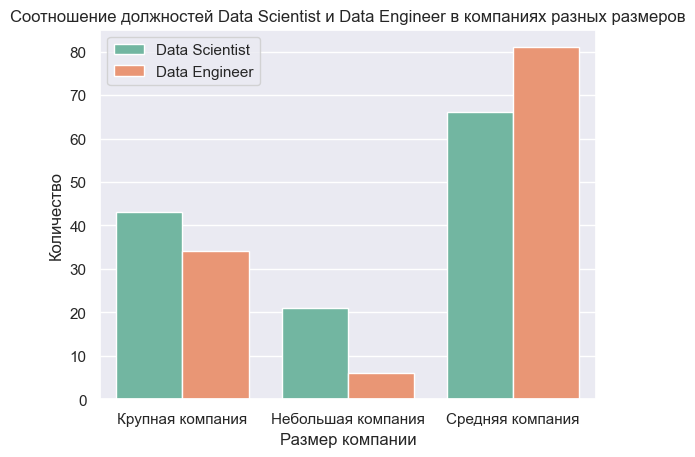

In [58]:
# Отберем данные в датасете по должностям Data Scientist и Data Engineer:
data_DS_DE = data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]

# Построим столбчатую диаграмму соотношения с помощью функции countplot() библиотеки seaborn:
ax = sns.countplot(
    data = data_DS_DE,
    x = data_DS_DE['company_size'], 
    hue = 'job_title'
)  
ax.legend()
ax.set(xlabel = 'Размер компании', ylabel = 'Количество')
plt.title('Соотношение должностей Data Scientist и Data Engineer в компаниях разных размеров')
plt.show()

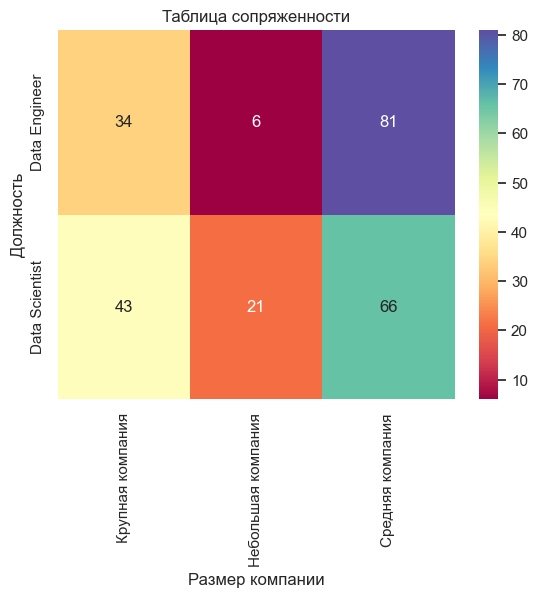

In [59]:
# Дополнительно составим таблицу сопряженности с помощью функции pd.crosstab и построим тепловую карту:

cross_tab = pd.crosstab(index = data_DS_DE['job_title'], columns = data_DS_DE['company_size'])
ax = sns.heatmap(cross_tab, annot = True, cmap='Spectral')
ax.set(xlabel = 'Размер компании', ylabel = 'Должность')
plt.title('Таблица сопряженности')
plt.show()


#### Выводы: 
В средних компаниях количество специалистов Data Scientist и Data Engineer больше, чем в остальных компаниях.

В небольших и крупных компаниях количество Data Scientist-ов больше, чем Data Engineer-ов. И только в средних компаниях наоборот.

Чтобы определить, являются ли эти различия статистически значимыми, далее будут проведены статистические тесты.

***

#### Общий вывод по п. визуальномц анализу данных: 
Таким образом на зарплату специалистов в сфере Data Science влияют следующие факторы:

* Год, в котором была выплачена зарплата. Предварительно можно сделать вывод, что с каждым годом зарплата у специалистов Data Scientist растет.
* Опыт работы на должности. Чем больше опыт - тем выше заработная плата. Максимальная зарплата у специалистов Executive-level/Director.
* Роль, в которой соискатель работал в течение года - у каждой должности своя зарплатная вилка.
* Основная страна проживания сотрудника в течение рабочего года. Максимальная зарплата у сотрудников из США.
* Общий объём работы, выполняемой удалённо. Зарплаты у сотрудников с полностью удаленной и с полностью офисной работой выше, чем при комбинированном формате.
* Страна главного офиса работодателя или филиала по контракту. Максимальная зарплата у сотрудников организаций из США.
* Среднее количество людей, работавших в компании в течение года. максимальная средняя зарплата у Data Scientist в средних компаниях размера M (от 50 до 250 * сотрудников). В небольших компаниях S (менее 50 сотрудников) зарплата более чем в 2 раза меньше по сравнению со средними компаниями.

***

## 4.3. Статистический анализ данных

In [60]:

# Подготовим функцию для принятия решения о нормальности:

def decision_normality(p):
    print('p-value = {:.3f}.'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным.'.format(alpha))
        
# Подготовим функцию для принятия решения об отклонении нулевой гипотезы:

def decision_hypothesis(p):
    print('p-value = {:.3f}.'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Нет оснований отвергнуть нулевую гипотезу'.format(alpha))

### 4.3.1. Влияет ли опыт работы на зарплату Data Scientist?

**Cформулируем нулевую и альтернативные гипотезы**

Нулевая гипотеза($H_0$): опыт работы не влияет на зарплату: Entry-level/Junior ($μ_1$), Mid-level/Intermediate ($μ_2$), Senior-level/Expert ($μ_3$)

 $H_0: μ_1 = μ_2 = μ_3$ 

Альтернативная гипотеза($H_1$): опыт работы влияет на зарплату: Entry-level/Junior ($μ_1$), Mid-level/Intermediate ($μ_2$), Senior-level/Expert ($μ_3$)

$H_1: μ_1 ≠ μ_2 ≠ μ_3 $

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [61]:
en = data_DS[data_DS['experience_level'] == 'EN'][ 'salary_in_usd']
mi = data_DS[data_DS['experience_level'] == 'MI'][ 'salary_in_usd']
se = data_DS[data_DS['experience_level'] == 'SE'][ 'salary_in_usd']


# проводим тест Шапиро-Уилка
print('Для Entry-level/Junior:')
result = stats.shapiro(en)
decision_normality(result[1])

print('Mid-level/Intermediate:')
result = stats.shapiro(mi)
decision_normality(result[1])

print('Senior-level/Expert:')
result = stats.shapiro(se)
decision_normality(result[1])


Для Entry-level/Junior:
p-value = 0.174.
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.
Mid-level/Intermediate:
p-value = 0.146.
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.
Senior-level/Expert:
p-value = 0.002.
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

1. Какой тип у признака 'salary_in_usd' ? — Количественный.
2. Сколько сравниваемых групп? — Три.
3. Группы зависимы? — Нет.
4. Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

In [62]:
_, p = stats.kruskal(en, mi, se)
decision_hypothesis(p)

p-value = 0.000.
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод

Есть основания утверждать, что опыт работы влияет на зарплату.

***

### 4.3.2. Влияет ли тип трудоустройства на зарплату Data Scientist?
**Сформулируем нулевую и альтернативные гипотезы**

Нулевая гипотеза ($H_0$): тип трудоустройства не влияет на зарплату: PT — неполный рабочий день ($μ_1$), FT — полный рабочий день ($μ_2$), FL — фриланс ($μ_3$).

$H_0: μ_1 = μ_2 = μ_3$

Альтернативная гипотеза ($H_1$): тип трудоустройства влияет на зарплату: PT — неполный рабочий день ($μ_1$), FT — полный рабочий день ($μ_2$), FL — фриланс ($μ_3$).

$H_1: μ_1 ≠ μ_2 ≠ μ_3$


**Проверка на нормальность**

С помощью теста Шапиро-Уилка нельзя полностью проверить признак, так как недостаточно данных для каждого праметра признака 'employment_type', поэтому воспользуемся графиком Q-Q plot.

In [63]:
ft = data_DS[data_DS['employment_type'] == 'FT']['salary_in_usd']
pt = data_DS[data_DS['employment_type'] == 'PT'][ 'salary_in_usd']
fl = data_DS[data_DS['employment_type'] == 'FL'][ 'salary_in_usd']

result = stats.shapiro(ft)
decision_normality(result[1])

p-value = 0.000.
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


Text(0.5, 1.0, 'Квантиль-квантиль график \n для распределения зарплаты в зависимости от графика работы')

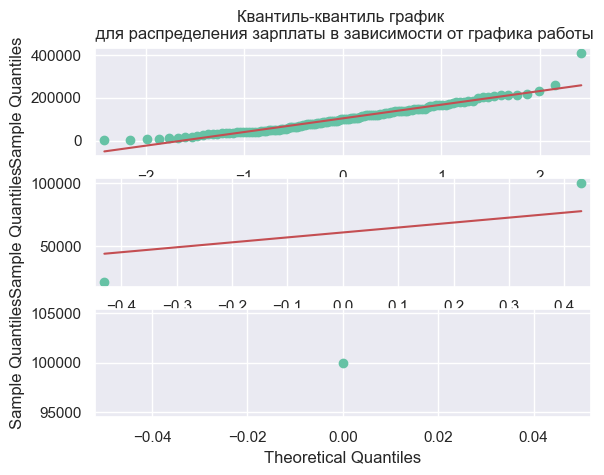

In [64]:
fig, axes = plt.subplots(nrows=3)
FT = sm.qqplot(data_DS[data_DS['employment_type'] == 'FT']['salary_in_usd'], line='s', ax=axes[0])
PT = sm.qqplot(data_DS[data_DS['employment_type'] == 'PT'][ 'salary_in_usd'], line='s', ax=axes[1])
FL = sm.qqplot(data_DS[data_DS['employment_type'] == 'FL'][ 'salary_in_usd'], line='s', ax=axes[2])
#sm.qqplot(ds_job.loc[ds_job['employment_type'] == 'PT', 'salary_in_usd'], line='s')
axes[0].set_title('Квантиль-квантиль график \n для распределения зарплаты в зависимости от графика работы')

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

1. Какой тип у признака 'salary_in_usd' ? — Количественный.
2. Сколько сравниваемых групп? — Три.
3. Группы зависимы? — Нет.
4. Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

In [65]:
_, p = stats.kruskal(ft, pt, fl)
decision_hypothesis(p)

p-value = 0.593.
p-значение больше, чем заданный уровень значимости 0.05. Нет оснований отвергнуть нулевую гипотезу


#### Вывод

Нету основания утверждать, что тип трудоустройства влияет на зарплату ,возможно, это из-за недостаточного количества данных.

***

### 4.3.3. Бизнес-вопрос: наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативную гипотезы**

Нулевая гипотеза ($H{_0}$): зарплаты у специалистов Data Scientist за 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($μ_3$) года не меняются или становятся меньше.

$H{_0}: μ_1 >= μ_2 >= μ_3$

Альтернативная гипотеза ($H{_1}$): зарплаты у специалистов Data Scientist за 2020 ($μ_1$), 2021 ($μ_2$), 2022 ($μ_3$) года увеличиваются.

$H{_1}: μ_1 < μ_2 < μ_3$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

Нулевая гипотеза ($H{_0}$): распределение данные является нормальным.

Альтернативная гипотеза ($H{_1}$): распределение данных отлично от нормального.

In [66]:
# Запишем в переменные значения зарплат за 2020, 2021 и 2022 года:

salary_2020 = data_DS[data_DS['work_year'] == 2020]['salary_in_usd']
salary_2021 = data_DS[data_DS['work_year'] == 2021]['salary_in_usd']
salary_2022 = data_DS[data_DS['work_year'] == 2022]['salary_in_usd']


# Проведем тест Шапиро-Уилка:

print('Для 2020 года:')
result1 = stats.shapiro(salary_2020)
decision_normality(result1[1])

print('Для 2021 года:')
result2 = stats.shapiro(salary_2021)
decision_normality(result2[1])

print('Для 2022 года:')
result3 = stats.shapiro(salary_2022)
decision_normality(result3[1])

Для 2020 года:
p-value = 0.000.
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Для 2021 года:
p-value = 0.107.
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.
Для 2022 года:
p-value = 0.676.
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.


Поскольку хотя бы в одной группе распределение отличается от нормального, используем непараметрические тесты.

**Выбор подходящего статистического теста:**

Используем алгоритм выбора теста:

1. Какой тип признака "Зарплата в долларах США"? - Количественный
2. Сколько сравниваемых групп? - Три
3. Группы зависимы? - Нет
4. Признак распределен по нормальному закону? - Нет

Таким образом, для проверки гипотезы используем критерий Краскела-Уоллиса.

In [67]:
_, p = stats.kruskal(salary_2020, salary_2021, salary_2022)
decision_hypothesis(p)

p-value = 0.000.
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод по тесту: 
C каждым годом зарплата у специалистов Data Scientist растет.

***

### 4.3.4. Бизнес-вопрос: как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
**Сформулируем нулевую и альтернативную гипотезы**

Нулевая гипотеза ($H{_0}$): зарплата у специалиста Data Scientist ($μ_1$) в 2022 году больше или равна зарплате специалиста Data Engineer ($μ_2$).

$H{_0}: μ_1 >= μ_2$

Альтернативная гипотеза ($H{_1}$): зарплата у специалиста Data Scientist ($μ_1$) в 2022 году меньше зарплаты специалиста Data Engineer ($μ_2$).

$H{_1}: μ_1 < μ_2$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

Нулевая гипотеза ($H{_0}$): распределение данные является нормальным.

Альтернативная гипотеза ($H{_1}$): распределение данных отлично от нормального.

In [68]:
# Запишем в переменные значения зарплат Data Scientist и Data Engineer за 2022 год:

salary_DS_2022 = data[(data['job_title'] == 'Data Scientist') & (data['work_year'] == 2022)]['salary_in_usd']
salary_DE_2022 = data[(data['job_title'] == 'Data Engineer') & (data['work_year'] == 2022)]['salary_in_usd']

# Проведем тест Шапиро-Уилка:

print('Для Data Scientist:')
result1 = stats.shapiro(salary_DS_2022)
decision_normality(result1[1])

print('Для Data Engineer:')
result1 = stats.shapiro(salary_DE_2022)
decision_normality(result1[1])

Для Data Scientist:
p-value = 0.676.
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.
Для Data Engineer:
p-value = 0.007.
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


Поскольку хотя бы в одной группе распределение отличается от нормального, используем непараметрические тесты.

**Выбор подходящего статистического теста:**

Используем алгоритм выбора теста:

1. Какой тип признака "Зарплата в долларах США"? - Количественный
2. Сколько сравниваемых групп? - Две
3. Группы зависимы? - Нет
4. Признак распределен по нормальному закону? - Нет

Таким образом, для проверки гипотезы используем U-критерий Манна-Уитни.

In [69]:
_, p = stats.mannwhitneyu(salary_DS_2022, salary_DE_2022, alternative = 'less')
decision_hypothesis(p)

p-value = 0.841.
p-значение больше, чем заданный уровень значимости 0.05. Нет оснований отвергнуть нулевую гипотезу


#### Вывод: 
Зарплата у специалиста Data Scientist в 2022 году больше или равна зарплате специалиста Data Engineer.

***

### 4.3.5. Бизнес-вопрос: как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
**Сформулируем нулевую и альтернативную гипотезы**

Нулевая гипотеза ($H{_0}$): зарплаты у специалистов Data Scientist в компаниях разных размеров одинаковы.

Альтернативная гипотеза ($H{_1}$): зарплаты у специалистов Data Scientist в компаниях разных размеров не одинаковы.

In [70]:
# Запишем в переменные значения зарплат Data Scientist в компаниях разных размеров:

salary_DS_S = data_DS[data_DS['company_size'] == 'Небольшая компания']['salary_in_usd']
salary_DS_M = data_DS[data_DS['company_size'] == 'Средняя компания']['salary_in_usd']
salary_DS_L = data_DS[data_DS['company_size'] == 'Крупная компания']['salary_in_usd']

# Проведем тест Шапиро-Уилка:

print('Для компании размера S — менее 50 сотрудников (небольшая компания):')
result1 = stats.shapiro(salary_DS_S)
decision_normality(result1[1])

print('Для компании размера M — от 50 до 250 сотрудников (средняя компания):')
result2 = stats.shapiro(salary_DS_M)
decision_normality(result2[1])

print('Для компании размера L — более 250 сотрудников (крупная компания):')
result3 = stats.shapiro(salary_DS_L)
decision_normality(result3[1])

Для компании размера S — менее 50 сотрудников (небольшая компания):
p-value = 0.189.
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.
Для компании размера M — от 50 до 250 сотрудников (средняя компания):
p-value = 0.897.
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.
Для компании размера L — более 250 сотрудников (крупная компания):
p-value = 0.000.
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


**Выбор подходящего статистического теста:**

Используем алгоритм выбора теста:

1. Какой тип признака "Зарплата в долларах США"? - Количественный
2. Сколько сравниваемых групп? - Три
3. Группы зависимы? - Нет
4. Признак распределен по нормальному закону? - Нет

Таким образом, для проверки гипотезы используем критерий Краскела-Уоллиса

In [71]:
_, p = stats.kruskal(salary_DS_S, salary_DS_M, salary_DS_L)
decision_hypothesis(p)

p-value = 0.000.
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод: 
Зарплаты у специалистов Data Scientist в компаниях разных размеров не одинаковы.
Есть основания утверждать, что размер компании влияет на зарплату.

***

### 4.3.6. Бизнес-вопрос: есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
**Сформулируем нулевую и альтернативную гипотезы**

Нулевая гипотеза ($H_0$): между наличием должностей Data Scientist и Data Engineer и размером компании нет взаимосвязи (признаки независимы).

Альтернативная гипотеза ($H_1$): между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь (признаки зависимы).

**Выбор подходящего статистического теста:**

Используем алгоритм выбора теста:

1. Какой тип признаков? - Категориальный
2. Сколько сравниваемых групп? - Две
3. Проверяется независимость групп? - Да

Таким образом, для проверки гипотезы используем критерий $χ^2$ (хи-квадрат)

In [72]:
# Составим таблицу сопряженности. Данные возьмем из датасета data_DS_DE, уже отобранного по должностям Data Scientist и Data Engineer:

cross_table = pd.crosstab(data_DS_DE['job_title'], data_DS_DE['company_size'])
cross_table

company_size,Крупная компания,Небольшая компания,Средняя компания
job_title,,,
Data Engineer,34,6,81
Data Scientist,43,21,66


In [73]:
# Выполним тест:

_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.005.
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод: 
Cуществует статистическая значимость между наличием должностей Data Scientist и Data Engineer и размером компании.

***

## 5. Дополнительные исследования
### 5.1 Бизнес-вопрос: в развитых странах средние зарплаты в сфере Data Science выше, чем в развивающихся?

Проверим гипотезу, которую выдвигали ранее при визуальном анализе данных, что в развитых странах средние зарплаты в сфере Data Science выше, чем в развивающихся.

In [74]:
# Еще раз выведем все значения столбца company_location, чтобы определить, какие страны участвуют в исследовании:
display(data_DS['company_location'].value_counts().to_frame().head(10))

,count
company_location,
US,72
GB,11
IN,8
FR,7
DE,6
CA,5
ES,3
AT,2
BR,1


C:\Users\user\AppData\Local\Temp\ipykernel_7212\1299397735.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



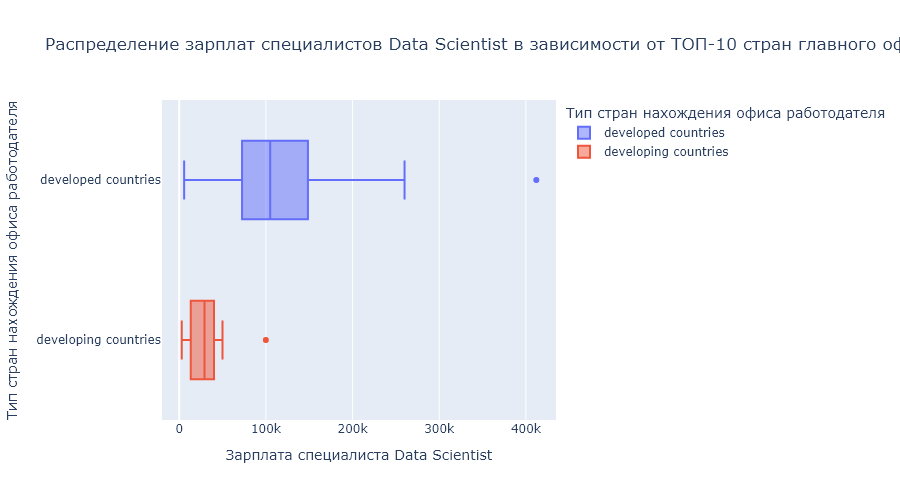

In [75]:
# Для проведения исследования разделим все данные на две группы по company_location (страна офиса работодателя) - на развитые и 
# развивающиеся страны.

# Определим списки развитых стран:

developed_countries = ['US', 'GB', 'CA', 'DE', 'FR', 'ES', 'GR', 'JP', 'NL', 'AT', 'PT', 'PL', 'LU', 'NL', 'AU', 'DK', 'IT', 'CZ', 'SI',
                       'CH', 'CN', 'BE', 'EE', 'SG', 'MT', 'IL', 'NZ']

# Остальные будут в списке развивающихся. Сформируем новый признак type_of_development с помощью lambda-функции:

data_DS['type_of_development'] = data_DS['company_location'].apply(
    lambda x: 'developed countries' if x in developed_countries else 'developing countries')

# Построим коробчатую диаграмму распределения признака зарплаты в разрезе развитых и развивающихся стран:


fig2 = px.box(
    data_frame=data_DS,
    x='salary_in_usd',
    y='type_of_development',
    color = 'type_of_development',
    height=500, #высота
    width=900, #ширина
    labels = {'type_of_development': 'Тип стран нахождения офиса работодателя'},
    title = 'Распределение зарплат специалистов Data Scientist в зависимости от ТОП-10 стран главного офиса',
)
fig2.update_layout(xaxis_title_text = 'Зарплата специалиста Data Scientist')
fig2.show('png')

#### Выводы по графику: 
Можно отметить, что медианная заралата в организациях из развитых стран намного выше, чем в развивающихся.

Также ответим на бизнес-вопрос с помощью статистических тестов.

**Сформулируем нулевую и альтернативную гипотезы**

Нулевая гипотеза ($H_0$): зарплаты у специалистов в сфере Data Science в развитых странах ($μ_1$) равны или меньше, чем в равивающихся ($μ_2$).

$H_0: μ_1 <= μ_2$

Альтернативная гипотеза ($H_1$): зарплаты у специалистов в сфере Data Science в развитых странах ($μ_1$) больше чем в равивающихся ($μ_2$).

$H_1: μ_1 > μ_2$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

Нулевая гипотеза ($H_0$): распределение данные является нормальным.

Альтернативная гипотеза ($H_1$): распределение данных отлично от нормального.

In [76]:
# Отберем данные по зарплатам по развитым и развивающимся странам:
data_developed = data_DS[data_DS['type_of_development'] == 'developed countries']['salary_in_usd']
data_developing = data_DS[data_DS['type_of_development'] == 'developing countries']['salary_in_usd']

# Проведем тест Шапиро-Уилка: 

print('Для развитых стран:')
result1 = stats.shapiro(data_developed)
decision_normality(result1[1])

print('Для развивающихся стран:')
result2 = stats.shapiro(data_developing)
decision_normality(result2[1])

Для развитых стран:
p-value = 0.000.
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Для развивающихся стран:
p-value = 0.006.
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


**Выбор подходящего статистического теста:**

Используем алгоритм выбора теста:

1. Какой тип признака "Зарплата в долларах США"? - Количественный
2. Сколько сравниваемых групп? - Две
3. Группы зависимы? - Нет
4. Признак распределен по нормальному закону? - Нет

Таким образом, для проверки гипотезы используем U-критерий Манна-Уитни

In [77]:
_, p = stats.mannwhitneyu(data_developed, data_developing, alternative = 'greater')
decision_hypothesis(p)

p-value = 0.000.
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод: 
Таким образом, в развитых странах средние зарплаты в сфере Data Science выше, чем в развивающихся.

***

### 5.2 Бизнес-вопрос: Как соотносятся зарплаты специалистов Data Scientist, Data Engineer и Data Analyst, которые находятся в США?
Визуальный анализ данных показал, что в организациях из США самые высокие зарплаты в сфере Data Science, а также у специалистов, которые находятся в США также самые высокие зарплаты.

Сравним, как соотносятся зарплаты специалистов из США по трем самым популярным должностям - Data Scientis, Data Engineer и Data Analyst.

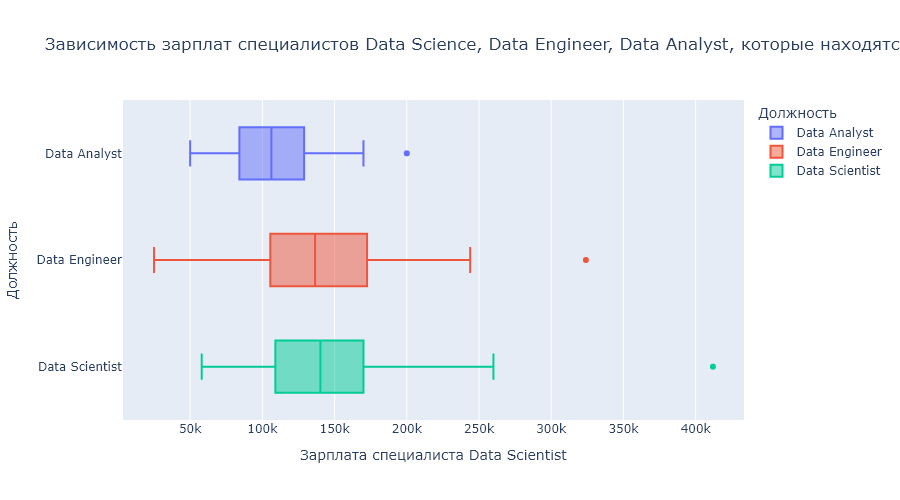

In [81]:
# Подготовим данные для иследования - отберем по стране проживания сотрудника (США) и должностям:

data_US_DS_SE_DA = data[(data['employee_residence'] == 'US') & (data['job_title'].isin(['Data Scientist', 'Data Engineer', 'Data Analyst']))]

# Построим коробчатую диаграмму распределения:

fig2 = px.box(
    data_frame=data_US_DS_SE_DA,
    x='salary_in_usd',
    y='job_title',
    color = 'job_title',
    height=500, #высота
    width=900, #ширина
    labels = {'job_title': 'Должность'},
    title = 'Зависимость зарплат специалистов Data Science, Data Engineer, Data Analyst, которые находятся в США',
)
fig2.update_layout(xaxis_title_text = 'Зарплата специалиста Data Scientist')
fig2.show('png')

#### Вывод по графику: 
Можно отметить, что медианные зарплаты у специалистов из США Data Scientist и Data Engineer примерно равны, а у Data Analyst немного ниже.


**Сформулируем нулевую и альтернативную гипотезы**

Нулевая гипотеза ($H_0$): зарплаты в США у специалистов Data Scientist, Data Engineer и Data Analyst одинаковы.

Альтернативная гипотеза ($H_1$): зарплаты в США у специалистов Data Scientist, Data Engineer и Data Analyst не одинаковы.

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

Нулевая гипотеза ($H_0$): распределение данные является нормальным.

Альтернативная гипотеза ($H_1$): распределение данных отлично от нормального.

In [79]:
# Подготовим данные для анализа - отберем по стране проживания соискателя США и должностям Data Scientist, Data Engineer, Data Analyst

data_US_DS = data[(data['employee_residence'] == 'US') & (data['job_title'] == 'Data Scientist')]['salary_in_usd']
data_US_DE = data[(data['employee_residence'] == 'US') & (data['job_title'] == 'Data Engineer')]['salary_in_usd']
data_US_DA = data[(data['employee_residence'] == 'US') & (data['job_title'] == 'Data Analyst')]['salary_in_usd']

# Проведем тест Шапиро-Уилка: 

print('Для Data Scientist:')
result1 = stats.shapiro(data_US_DS)
decision_normality(result1[1])

print('Для Data Engineer:')
result2 = stats.shapiro(data_US_DE)
decision_normality(result2[1])

print('Для Data Analyst:')
result3 = stats.shapiro(data_US_DA)
decision_normality(result3[1])

Для Data Scientist:
p-value = 0.000.
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Для Data Engineer:
p-value = 0.160.
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.
Для Data Analyst:
p-value = 0.529.
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.


**Выбор подходящего статистического теста:**

Используем алгоритм выбора теста:

1. Какой тип признака "Зарплата в долларах США"? - Количественный
2. Сколько сравниваемых групп? - Три
3. Группы зависимы? - Нет
4. Признак распределен по нормальному закону? - Нет

Таким образом, для проверки гипотезы используем критерий Краскела-Уоллиса

In [80]:
_, p = stats.kruskal(data_US_DS, data_US_DE, data_US_DA)
decision_hypothesis(p)

p-value = 0.000.
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод: 
Таким образом, зарплаты специалистов Data Scientist, Data Engineer, Data Analyst не одинаковы.

***

### Общий вывод: 
Таким образом, на зарплаты в сфере Data Science влияют несколько факторов, а именно:

* Год, в котором была выплачена зарплата.
* Нету основания утверждать, что тип трудоустройства влияет на зарплату ,возможно, это из-за недостаточного количества данных.
* Опыт работы на должности.
* Должность специалиста.
* Основная страна проживания сотрудника в течение рабочего года.
* Формат работы.
* Страна главного офиса работодателя или филиала по контракту.
* Есть основания утверждать, что размер компании влияет на зарплату.
* Есть основания утверждать, что c каждым годом зарплата Data Scientist увеличивается.
* Существует статистически значимая взаимосвязь должностями Data Scientist и Data Engineer и размером компании.